In [18]:
#from google.colab import drive
#drive.mount('/content/gdrive')
import warnings
warnings.filterwarnings("ignore")

target_height = 400
target_width = 400

## ROI LOAD
import scipy.io
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import time
import keras
from keras.preprocessing import image# for RGB images
import os
from tqdm import tqdm
from numpy import ndarray as nd
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
import cv2# cv2.imread() for grayscale images
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
path='/home/giorgostsekas92/msot_muscle_segmentation/MSOT_data/'
%cd MSOT_data/
data='msot_data_baseline'
Nimages = len(os.listdir(path+data)) # total images in path

/home/giorgostsekas92/msot_muscle_segmentation/MSOT_data


In [2]:
def full_data_load():
    # load the filenames of all images
    img_filenames = np.array(sorted(os.listdir(data)))#sort to alphabetical order
    assert len(img_filenames)==Nimages
    wells = [f.split('.mat')[0] for f in img_filenames]
    wells = np.sort(np.unique(wells))
    #channels = np.arange(1,29) ## full channel approach
    channels = np.array([6,11,16,24,28])
    #%%load the images
    X = np.zeros(shape=(Nimages,target_height,target_width,5),dtype='float32')
    Y = np.zeros(shape=(Nimages,target_height,target_width,1),dtype='float32')

    i=0
    for w in  wells:
        print('loading image ',i)
        j=0
        for c in channels:
            #print(c)
            key = w
            img_file = None
            for f in img_filenames:
                if key in f:
                    img_file=f
                    break;
            #load the image
            img = scipy.io.loadmat(data+'/'+img_file)['Recons'][:,:,c-1]
            #normalize to 0-1
            img=img/img.max()
            X[i,:,:,j]=img
            j=j+1
        img = scipy.io.loadmat(data+'/'+w)['roimask']
        #normalize to 0-1
        img=img/img.max()
        #create binary image from [0,1] to {0,1}, using 0.5 as threshold
        img[img<0.5]=0
        img[img>=0.5]=1
        Y[i,:,:,0]=img
        i=i+1
    #double-check that the masks are binary
    assert np.array_equal(np.unique(Y), [0,1])

    #%% split into train, validation and test sets

    ix = np.arange(len(wells))

    ix_tr, ix_val_ts = train_test_split(ix,train_size=60, random_state=0)
    ix_val, ix_ts = train_test_split(ix_val_ts,train_size=20, random_state=0)

    #sanity check, no overlap between train, validation and test sets
    assert len(np.intersect1d(ix_tr,ix_val))==0
    assert len(np.intersect1d(ix_tr,ix_ts))==0
    assert len(np.intersect1d(ix_val,ix_ts))==0
    print(ix_tr.shape,ix_val.shape,ix_ts.shape)
    
    X_tr = X[ix_tr,:]
    Y_tr = Y[ix_tr,:]
    print(X_tr.shape,Y_tr.shape)
    X_val = X[ix_val,:]
    Y_val = Y[ix_val,:]
    print(X_val.shape,Y_val.shape)
    X_ts = X[ix_ts,:]
    Y_ts = Y[ix_ts,:]
    print(X_ts.shape,Y_ts.shape)
    fnames_tr = wells[ix_tr].tolist()
    fnames_val = wells[ix_val].tolist()
    fnames_ts = wells[ix_ts].tolist()

    fname_split = ['train']*len(fnames_tr)+['validation']*len(fnames_val)+['test']*len(fnames_ts)
    df=pd.DataFrame({'well':fnames_tr+fnames_val+fnames_ts,
                  'split':fname_split})

    #save to disk
    df.to_csv('./training_validation_test_splits.csv',index=False)

    np.save('./X_tr.npy',X_tr)
    np.save('./X_val.npy',X_val)
    np.save('./X_ts.npy',X_ts)
    np.save('./Υ_tr.npy',Y_tr)
    np.save('./Y_val.npy',Y_val)
    np.save('./Y_ts.npy',Y_ts)

In [21]:
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """
    Add a vertical color bar to an image plot.
    https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    """
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)


def data_load(sg):
    # load the filenames of all images
    img_filenames = np.array(sorted(os.listdir(data)))#sort to alphabetical order
    assert len(img_filenames)==Nimages
    wells = [f.split('.mat')[0] for f in img_filenames]
    wells = np.sort(np.unique(wells))
    channels = np.arange(1,29) # full channel approach
    #channels = np.array([6,11,16,24,28]) #top5 channel approach 
    #%%load the images
    X = np.zeros(shape=(Nimages,target_height,target_width,28),dtype='float32')
    Y = np.zeros(shape=(Nimages,target_height,target_width,1),dtype='float32')

    i=0
    for w in  wells:
        print('loading image ',i)
        j=0
        for c in channels:
            key = w
            img_file = None
            for f in img_filenames:
                if key in f:
                    img_file=f
                    break;
            #cv2 is better for grayscale images, use 
            #load the image
            img = scipy.io.loadmat(data+'/'+img_file)['Recons'][:,:,c-1]
            #print(img.shape)
            #resize
            #img=cv2.resize(img,(target_width,target_height))
            #normalize to 0-1
            img=img/img.max()
            X[i,:,:,c-1]=img
            #j=j+1 #top5 channel approach 
        #print('loading mask')
        img = scipy.io.loadmat(data+'/'+w)['roimask']
        #resize
        #img=cv2.resize(img,(target_width,target_height))
        #normalize to 0-1
        img=img/img.max()
        #create binary image from [0,1] to {0,1}, using 0.5 as threshold
        img[img<0.5]=0
        img[img>=0.5]=1
        Y[i,:,:,0]=img
        i=i+1
        #print()#add a blank line for readability

    #double-check that the masks are binary
    assert np.array_equal(np.unique(Y), [0,1])


    #%% split into train, validation and test sets

    ix = np.arange(len(wells))

    ix_tr, ix_val_ts = train_test_split(ix,train_size=80, random_state=0)
    ix_val, ix_ts = train_test_split(ix_val_ts,train_size=10, random_state=0)

    #sanity check, no overlap between train, validation and test sets
    assert len(np.intersect1d(ix_tr,ix_val))==0
    assert len(np.intersect1d(ix_tr,ix_ts))==0
    assert len(np.intersect1d(ix_val,ix_ts))==0
    print(ix_tr.shape,ix_val.shape,ix_ts.shape)
    X_val = X[ix_val,:]
    Y_val = Y[ix_val,:]

    X_ts = X[ix_ts,:]
    Y_ts = Y[ix_ts,:]
    
    ## HERE we initially start with 10% of images only ! suggestive-annotation mode
    if len(sg)==0:
        ix_annot, ix_unannot = train_test_split(ix_tr,train_size=0.25, random_state=0) # here splitting the set into annotated and unannotated training images (to be annotated subsequently)
    if len(sg)!=0:
        #initialization using .csv column 'idx'
        df_temp=pd.read_csv('./training_validation_test_splits.csv')
        ix_annot=df_temp[df_temp['split']=='train']['idx']
        df_temp1=pd.read_csv('./training_pool.csv')
        ix_unannot=np.array(df_temp1[df_temp1['split']=='train']['idx'])     
        
        for j in sg:
            ix_annot=np.append(ix_annot,j)
            #print(ix_annot)
            ix_unannot = np.delete(ix_unannot, np.where(ix_unannot == j))
            #print(ix_unannot)
    print(len(ix_annot))
    print(len(ix_unannot))

    X_tr=X[ix_annot,:]
    Y_tr=Y[ix_annot,:]

    X_pool=X[ix_unannot,:]
    Y_pool=Y[ix_unannot,:]

    fnames_tr = wells[ix_annot].tolist()
    fnames_pool = wells[ix_unannot].tolist()
    fnames_val = wells[ix_val].tolist()
    fnames_ts = wells[ix_ts].tolist()

    fname_split = ['train']*len(fnames_tr)+['validation']*len(fnames_val)+['test']*len(fnames_ts)
    df=pd.DataFrame({'well':fnames_tr+fnames_val+fnames_ts,
                  'split':fname_split,
                  'idx': np.append(np.append(ix_annot,ix_val),ix_ts)})

    df1=pd.DataFrame({'well':fnames_pool,'split':'train','idx':ix_unannot})


    #save to disk
    df.to_csv('./training_validation_test_splits.csv',index=False)
    df1.to_csv('./training_pool.csv',index=False)

    np.save('./X_tr.npy',X_tr)
    np.save('./X_pool.npy',X_pool)
    np.save('./X_val.npy',X_val)
    np.save('./X_ts.npy',X_ts)

    np.save('./Y_tr.npy',Y_tr)
    np.save('./Y_pool.npy',Y_pool)
    np.save('./Y_val.npy',Y_val)
    np.save('./Y_ts.npy',Y_ts)

In [22]:
#%% set-up the UNET model
import numpy as np
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import AveragePooling2D,GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Conv2DTranspose
from keras.layers.merge import concatenate

def UNET(input):

    #model parameters
    bnorm_axis = -1
    #filter sizes of the original model
    nfilters = np.array([64, 128, 256, 512, 1024])

    #downsize the UNET for this example.
    #the smaller network is faster to train
    #and produces excellent results on the dataset at hand
    nfilters = (nfilters/8).astype('int')

    #input
    input_tensor = Input(shape=input.shape[1:], name='input_tensor')

    ####################################
    # encoder (contracting path)
    ####################################
    #encoder block 0
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(input_tensor)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(e0)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)

    #encoder block 1
    e1 = MaxPooling2D((2, 2))(e0)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)

    #encoder block 2
    e2 = MaxPooling2D((2, 2))(e1)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)

    #encoder block 3
    e3 = MaxPooling2D((2, 2))(e2)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)

    #encoder block 4
    e4 = MaxPooling2D((2, 2))(e3)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    #e4 = MaxPooling2D((2, 2))(e4)
    ####################################
    # decoder (expansive path)
    ####################################

    #decoder block 3
    d3=UpSampling2D((2, 2),)(e4)
    d3=concatenate([e3,d3], axis=-1)#skip connection
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)

    #decoder block 2
    d2=UpSampling2D((2, 2),)(d3)
    d2=concatenate([e2,d2], axis=-1)#skip connection
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)

    #decoder block 1
    d1=UpSampling2D((2, 2),)(d2)
    d1=concatenate([e1,d1], axis=-1)#skip connection
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)

    #decoder block 0
    d0=UpSampling2D((2, 2),)(d1)
    d0=concatenate([e0,d0], axis=-1)#skip connection
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)

    #output
    out_class = Dense(1)(d0)
    out_class = Activation('sigmoid',name='output')(out_class)

    #create and compile the model
    model=Model(inputs=input_tensor,outputs=out_class)
    model.compile(loss={'output':'binary_crossentropy'},
                  metrics={'output':'accuracy'},
                  optimizer='adam')
    #model.summary()
    #plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)
    return model

In [23]:
#UNET with dropout layers (p=0.5)
def UNET_mc(input):

    #model parameters
    bnorm_axis = -1
    #filter sizes of the original model
    nfilters = np.array([64, 128, 256, 512, 1024])

    #downsize the UNET for this example.
    #the smaller network is faster to train
    #and produces excellent results on the dataset at hand
    nfilters = (nfilters/8).astype('int')

    #input
    input_tensor = Input(shape=input.shape[1:], name='input_tensor')

    ####################################
    # encoder (contracting path)
    ####################################
    #encoder block 0
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(input_tensor)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(e0)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)

    #encoder block 1
    e1 = MaxPooling2D((2, 2))(e0)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)

    #encoder block 2
    e2 = MaxPooling2D((2, 2))(e1)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)
    e2 = Dropout(0.5)(e2,training=True)

    #encoder block 3
    e3 = MaxPooling2D((2, 2))(e2)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)
    e3 = Dropout(0.5)(e3,training=True)

    #encoder block 4
    e4 = MaxPooling2D((2, 2))(e3)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    #e4 = MaxPooling2D((2, 2))(e4)
    e4 = Dropout(0.5)(e4,training=True)
    ####################################
    # decoder (expansive path)
    ####################################

    #decoder block 3
    d3=UpSampling2D((2, 2),)(e4)
    d3=concatenate([e3,d3], axis=-1)#skip connection
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)
    d3 = Dropout(0.5)(d3,training=True)

    #decoder block 2
    d2=UpSampling2D((2, 2),)(d3)
    d2=concatenate([e2,d2], axis=-1)#skip connection
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)
    d2 = Dropout(0.5)(d2,training=True)

    #decoder block 1
    d1=UpSampling2D((2, 2),)(d2)
    d1=concatenate([e1,d1], axis=-1)#skip connection
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)
    d1 = Dropout(0.5)(d1,training=True)

    #decoder block 0
    d0=UpSampling2D((2, 2),)(d1)
    d0=concatenate([e0,d0], axis=-1)#skip connection
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)

    #output
    out_class = Dense(1)(d0)
    out_class = Activation('sigmoid',name='output')(out_class)

    #create and compile the model
    model=Model(inputs=input_tensor,outputs=out_class)
    model.compile(loss={'output':'binary_crossentropy'},
                  metrics={'output':'accuracy'},
                  optimizer='adam')
    #plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)
    return model

In [24]:
#create vgg-style cnn for segmentation quality estimation


def DiceNet(input1):
    
    #model parameters
    bnorm_axis = -1
    #filter sizes of the original model
    nfilters = np.array([32, 64, 128, 256])

    #inputs
    input_tensor = Input(shape=input1.shape[1:], name='input')
    
        #Conv block #1
    x = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(input_tensor)
    x = BatchNormalization(axis=bnorm_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization(axis=bnorm_axis)(x)
    x = Activation('relu')(x)

    #max-pooling #1 
    x = MaxPooling2D((2, 2))(x)

    #Conv block #2
    x = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization(axis=bnorm_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization(axis=bnorm_axis)(x)
    x = Activation('relu')(x)

    #max-pooling #2
    x = MaxPooling2D((2, 2))(x)

    #Conv block #3
    x = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization(axis=bnorm_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization(axis=bnorm_axis)(x)
    x = Activation('relu')(x)

    #max-pooling #3
    x = MaxPooling2D((2, 2))(x)

    #Conv block #4
    x = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization(axis=bnorm_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization(axis=bnorm_axis)(x)
    x = Activation('relu')(x)

    #global average pooling
    x = GlobalAveragePooling2D()(x)

    #output
    x = Dense(1)(x)
    output = Activation('sigmoid',name='output')(x)
    #create and compile the model
    model=Model(inputs=input_tensor,outputs=output)
    model.summary()
    model.compile(loss={'output':'mse'}, optimizer='adam')

    return model

In [25]:
def uncertainty_calc(X,model,bz,sample_times):
    #MC Dropout implementation
    
    for batch_id in tqdm(range(X.shape[0] // bz)):
        # initialize our predictions
        Y_hat = np.zeros(shape=(sample_times,X.shape[0],target_height,target_width,1),dtype='float32')
        #print(Y_ts_hat.shape) 
        
        start = time.time() # MC dropout is starting !!
        
        for sample_id in range(sample_times):
            # predict stochastic dropout model T times
            Y_hat[sample_id] = model.predict(X, bz)
        # average over all passes
        prediction = Y_hat.mean(axis=0)       
        uncertainty_mc= -(prediction*np.log2(prediction) + (1-prediction)*np.log2(1-prediction)) ## entropy = -(p*np.log2(p) + (1-p)*np.log(1-p))
        end = time.time()        
        chkpnt=(end-start) # this is how long it lasts for all images of the test set, for MC Dropout-based Uncertainty Estimation
        
        #%% convert predictedυγιείς mask to binary
        threshold=0.5
        prediction[prediction<threshold]=0
        prediction[prediction>=threshold]=1
        print("\n Time needed for MC Dropout-based Uncertainty Estimation  ",chkpnt)

    return prediction,uncertainty_mc

def dice2D(a,b):
    intersection = np.sum(a[b==1])
    dice = (2*intersection)/(np.sum(a)+np.sum(b))
    if (np.sum(a)+np.sum(b))==0: #black/empty masks
        dice=1.0
    return(dice)

In [35]:
# -*- coding: utf-8 -*-

#if used on a non-GUI server ######
import matplotlib
matplotlib.use('Agg')
###################################

import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
#import h5py
import sys
#from model import *
#from keras.utils.vis_utils import plot_model

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import time
import skimage.transform

def rotateT(X,angle):
    #rotate image tensor, TF order, single channel
    X_rot = np.zeros_like(X)
    #repeat for every channel
    for ch in np.arange(X.shape[-1]):
        #print('channel',ch)
        #repeat for every image
        for i in np.arange(X.shape[0]):
            #print('image',i)
            X_rot[i,:,:,ch] = skimage.transform.rotate(X[i,:,:,ch],angle=angle,resize=False,preserve_range=True,mode='edge')
    return(X_rot)

def shiftT(X,dx,dy):
    #rotate image tensor, TF order, single channel
    X_shift = np.zeros_like(X)
    #repeat for every image
    tform = skimage.transform.SimilarityTransform(translation=(dx, dy))
    for i in np.arange(X.shape[0]):
        #print('image',i)
        X_shift[i,:,:,:] = skimage.transform.warp(X[i,:,:,:],tform,mode='edge')
    return(X_shift)

#%%
def aug_generator(X_raw=None,Y_raw=None,
                  batch_size=4,
                  flip_axes=['x','y'],
                  rotation_angles=[5,15]):
                  #noise_gaussian_mean=0,
                  #noise_gaussian_var=1e-2):
                  #noise_snp_amount=0.05):
    
    batch_size=batch_size#recommended batch size    
    Ndatapoints = len(X_raw)
    #Naugmentations=4 #original + flip, rotation, noise_gaussian, noise_snp
    
    while(True):
        #print('start!')
        ix_randomized = np.random.choice(Ndatapoints,size=Ndatapoints,replace=False)
        ix_batches = np.array_split(ix_randomized,int(Ndatapoints/batch_size))
        for b in range(len(ix_batches)):
            #print('step',b,'of',len(ix_batches))
            ix_batch = ix_batches[b]
            current_batch_size=len(ix_batch)
            #print('size of current batch',current_batch_size)
            #print(ix_batch)
            X_batch = X_raw[ix_batch,:,:,:].copy()#.copy() to leave original unchanged
            Y_batch = Y_raw[ix_batch,:,:,:].copy()#.copy() to leave original unchanged
            
            #now do augmentation on images and masks
            #iterate over each image in the batch
            for img in range(current_batch_size):
                #print('current_image',img,': ',ix_batch[img])
                do_aug=np.random.choice([True, False],size=1)[0]#50-50 chance
                if do_aug == True:
                    #print('flipping',img)
                    flip_axis_selected = np.random.choice(flip_axes,1,replace=False)[0]
                    if flip_axis_selected == 'x':
                        flip_axis_selected = 1
                    else: # 'y'
                        flip_axis_selected = 0
                    #flip an axis
                    X_batch[img,:,:,:] = np.flip(X_batch[img,:,:,:],axis=flip_axis_selected)
                    Y_batch[img,:,:,:] = np.flip(Y_batch[img,:,:,:],axis=flip_axis_selected)
                    #print('Flip on axis',flip_axis_selected)
                
                do_aug=np.random.choice([True, False],size=1)[0]#50-50 chance
                if do_aug == True:
                    #print('rotating',img)
                    rotation_angle_selected = np.random.uniform(low=rotation_angles[0],high=rotation_angles[1],size=1)[0]
                    #rotate the image
                    X_batch[img,:,:,:] = rotateT(np.expand_dims(X_batch[img,:,:,:],axis=0),angle=rotation_angle_selected)
                    Y_batch[img,:,:,:] = rotateT(np.expand_dims(Y_batch[img,:,:,:],axis=0),angle=rotation_angle_selected)
                    #print('Rotate angle',rotation_angle_selected)
            yield(X_batch,Y_batch)
            #print('step end after',b,'of',len(ix_batches))
            
            
def train(mc=False):
    
    from keras import backend as K
    K.clear_session()
    model={}
    #load the data from already split files
    X_tr = np.load('./X_tr.npy')
    Y_tr = np.load('./Υ_tr.npy')
    print('START TRAINING......:')
    print('Training with '+str(X_tr.shape[0])+' images')
    X_val = np.load('./X_val.npy')
    Y_val = np.load('./Y_val.npy')
    print('Validating with '+str(X_val.shape[0])+' images')
    #%% train the model
    filepath = 'unet_div8_495K_'

    #save the model when val_loss improves during training
    #hFile = h5py.File('./trained_models/'+filepath+'_'+mode+'.hdf5')
    checkpoint = ModelCheckpoint('./trained_models/'+filepath+str(X_tr.shape[0])+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    #save training progress in a .csv
    csvlog = CSVLogger('./trained_models/'+filepath+str(X_tr.shape[0])+'_train_log.csv',append=True)
    #stop training if no improvement has been seen on val_loss for a while
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=12)
    batch_size=3
    
    #initialize the generator
    gen_train = aug_generator(X_tr,Y_tr,batch_size=batch_size,flip_axes=[1,2])
    #split the array and see how many splits there are to determine #steps
    steps_per_epoch_tr = len(np.array_split(np.zeros(len(X_tr)),int(len(X_tr)/batch_size)))
    
    ## Step 1: Training UNET
    
    # Setup the model
    if (mc==False): 
        print("Training simple Unet")
        
        model=UNET(X_tr)
    else:
        print("Training Unet-mcdropout")
        print(X_tr.shape)
        model=UNET_mc(X_tr)
        
    #actually do the training
    model.fit_generator(gen_train,
                          steps_per_epoch=steps_per_epoch_tr,#the generator internally goes over the entire dataset in one iteration
                          validation_data=(X_val,Y_val),
                          epochs=80,
                          verbose=2,
                          initial_epoch=0,
                          callbacks=[checkpoint, csvlog, early_stopping])
    
    if mc==True:
        predictions,uncertainty_mc=uncertainty_calc(X_tr,model,1,sample_times=20)
        val_predictions,val_uncertainty_mc=uncertainty_calc(X_val,model,1,sample_times=20)
        
        ## Step 2: Training DiceNet
        
        merged=np.concatenate((X_tr,predictions,uncertainty_mc),axis=-1)
        val_merged=np.concatenate((X_val,val_predictions,val_uncertainty_mc),axis=-1)

        model_dice=DiceNet(merged)
        #save the model when val_loss improves during training
        #f = h5py.File('./trained_models/'+filepath+'_'+mode+'DiceNet.hdf5')
        checkpoint = ModelCheckpoint('./trained_models/'+filepath+str(X_tr.shape[0])+'_DiceNet.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
        #f.close()
        #save training progress in a .csv
        csvlog = CSVLogger('./trained_models/'+filepath+str(X_tr.shape[0])+'_DiceNet_train_log.csv',append=True)
        #%% calculate dice
        dice = []
        dice_val=[]
        N=len(X_tr)
        for i in range(N):
            dice.append(dice2D(Y_tr[i,:,:,0],predictions[i,:,:,0]))
        #gen_train_diceNet = aug_generator(merged,np.median(dice),batch_size=batch_size,flip_axes=[1,2])
        d=np.array(dice)
        d = d.reshape(-1, 1)
        print(d.shape)
        N=len(X_val)
        for i in range(N):
            dice_val.append(dice2D(Y_val[i,:,:,0],val_predictions[i,:,:,0]))
        #gen_train_diceNet = aug_generator(merged,np.median(dice),batch_size=batch_size,flip_axes=[1,2])
        #d_val=np.array(dice_val)
        #d_val = d_val.reshape(-1, 1)
        model_dice.fit(merged,d,
                          #steps_per_epoch=steps_per_epoch_tr,#the generator internally goes over the entire dataset in one iteration
                          validation_data=(val_merged,dice_val),
                          epochs=60,
                          verbose=2,
                          initial_epoch=0,
                          callbacks=[checkpoint, csvlog, early_stopping])
        del model_dice
        hFile = h5py.File('./trained_models/'+filepath+str(X_tr.shape[0])+'.hdf5','r')
        hFile.close()
        print(hFile.__bool__())
        hFile = h5py.File('./trained_models/'+filepath+str(X_tr.shape[0])+'_DiceNet.hdf5','r')
        hFile.close()
        print(hFile.__bool__())
        #print(X_tr.shape,predictions.shape,uncertainty_mc.shape)
    del model
    #print(hFile.__bool__())

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

  
def eval(mode):  ## evaluation function for simple UNet
    if mode=='pool':
        X = np.load('./X_pool.npy')
        Y = np.load('./Y_pool.npy')#.astype('float32')#to match keras predicted mask
    elif mode=='test':
        X = np.load('./X_ts.npy')
        Y = np.load('./Y_ts.npy')
    X_tr = np.load('./X_tr.npy') # just to set the correct name based on the size
    print('START EVALUATION......:')
    N=len(X)

    df = pd.read_csv('./training_validation_test_splits.csv')
    well_ts = df[df['split']=='test']['well'].tolist()
    #Y_ts is a binary mask
    #np.unique(Y_ts)
    #array([ 0.,  1.], dtype=float32)

    #%% get predicted masks for test set
    model = load_model('./trained_models/unet_div8_495K_'+str(X_tr.shape[0])+'.hdf5')
    print("Loading model: "+'./trained_models/unet_div8_495K_'+str(X_tr.shape[0])+'.hdf5')
    
    start = time.time()
    Y_hat = model.predict(X,batch_size=1)
    #print(Y_ts_hat.shape)
    #max_softmax=softmaxEquation(p_hat)
    end = time.time()
    chkpnt=(end-start) # this is how long it lasts for all images of the test set, for Maximum Softmax Probability-based Uncertainty Estimation
    print("\n Time needed for Maximum Softmax Probability-based Uncertainty Estimation  ",chkpnt)

    #%% convert predicted mask to binary
    threshold=0.5
    Y_hat[Y_hat<threshold]=0
    Y_hat[Y_hat>=threshold]=1
     
    #%% calculate dice
    dice = []
    for i in range(N):
        dice.append(dice2D(Y[i,:,:,0],Y_hat[i,:,:,0]))
    #dice = np.array(dice)
    return Y_hat,dice

def eval_mc(mode,sample_times=5): # evaluation function for MC Dropout UNet
    print('START EVALUATION......:')
    if mode=='pool':
        X = np.load('./X_pool.npy')
    elif mode=='test':
        X = np.load('./X_ts.npy')
        
    X_tr = np.load('./X_tr.npy')  # just to set the correct name based on the size

    print(X.shape)
    Ntest=len(X)
    df = pd.read_csv('./training_validation_test_splits.csv')
    well_ts = df[df['split']=='test']['well'].tolist()
  
    #%% get predicted masks for test set
    print("Loading model: "+'./trained_models/unet_div8_495K_'+str(X_tr.shape[0])+'.hdf5')
    f = h5py.File('./trained_models/unet_div8_495K_'+str(X_tr.shape[0])+'.hdf5')
    f.close()
    model = load_model('./trained_models/unet_div8_495K_'+str(X_tr.shape[0])+'.hdf5')
    #print(f.__bool__())
    
    pred,uncertainty_mc=uncertainty_calc(X,model,1,sample_times)
    return pred,uncertainty_mc

def eval_DiceNet(mode):  # evaluation function for the DiceNet network
    if mode=='pool':
        X = np.load('./X_pool.npy')
    elif mode=='test':
        X = np.load('./X_ts.npy')
        
    X_tr = np.load('./X_tr.npy')  # just to set the correct name based on the size

    #%% get predicted masks for test set
    print("Loading model: "+'./trained_models/unet_div8_495K_'+str(X_tr.shape[0])+'_DiceNet.hdf5')
    #f = h5py.File('./trained_models/unet_div8_495K_'+str(X_tr.shape[0])+'_DiceNet.hdf5')
    #f.close()
    model = load_model('./trained_models/unet_div8_495K_'+str(X_tr.shape[0])+'_DiceNet.hdf5')
    #print(f.__bool__())
    p,uncertainty_mc = eval_mc(mode)
    merged=np.concatenate((X,p,uncertainty_mc),axis=-1)
    qest=model.predict(merged)
    return qest

In [37]:
import random as r
def sample_prediction(dc,sample_size,random=False):
    dc=np.asarray(dc, dtype=np.float32)
    dc = dc.ravel()
    df = pd.read_csv('./training_pool.csv')
    sug_annot=[]
    if random==True: # receives random samples and feeds them to the RANDOM - annotation procedure 
        #while len(sug_annot)<6:
        #idx=r.randint(0,df.shape[0])
        #if ((df['idx']==idx).any())==True:
        #    indices=df['idx'].iloc[idx]
        #    sug_annot.append(indices)
        idx = np.argpartition(dc, sample_size)
        idx=r.sample(list(idx),sample_size)
        indices=df['idx'].loc[idx]
        for i in range (len(indices)):
                     sug_annot.append(indices.iloc[i])
    else:     # predicts worse n (n=sample_size) samples in the X_pool set, then appends their indices in a list for future annotation
        idx = np.argpartition(dc, -sample_size)[-sample_size:]
        indices=df['idx'].loc[idx]
        for i in range (indices.shape[0]):
             sug_annot.append(indices.iloc[i])
    return sug_annot

def dice_pred(p,Y_ts):
    d=[]
    for i in range(Y_ts.shape[0]):
    #plt.imshow(Y_ts[0,:,:,0])
    #plt.show()
    #plt.imshow(p[0,:,:,0])
    #plt.show()
    #plt.imshow(unc[0,:,:,0])
    #plt.show()
        d.append((dice2D(p[i,:,:,0],Y_ts[i,:,:,0])))
    return d

In [38]:
def unc_plot(X_ts,Y_ts,p,uncertainty_mc,perc):
    num = 5
    for i in range(num):
        #sample = np.random.randint(0,len(X_ts[i,:,:,0]))
        #image = X_predict[sample]
        #gt    = Y_predict[sample]

        #gt    = np.squeeze(gt)

        #n = np.random.randint(0,num)
        fig, ax = plt.subplots(2,2,figsize=(12,6))

        fig.suptitle('Dice: {:.2f}'.format((dice2D(p[i,:,:,0],Y_ts[i,:,:,0]))), y=1.0, fontsize=14)

        cax0 = ax[0,0].imshow(X_ts[i,:,:,0])
        plt.colorbar(cax0, ax=ax[0,0])
        ax[0,0].set_title('weight mask 1')

        #cax1 = ax[0,1].imshow(segm[i,:,:,0])
        #plt.colorbar(cax1, ax=ax[0,1])
        #ax[0,1].set_title('Max Probability')
        #ax[0,1].set_ylabel('Prediction')

        cax2 = ax[0,1].imshow(p[i,:,:,0])
        plt.colorbar(cax2, ax=ax[0,1])
        ax[0,1].set_title('MC-Dropout')
        ax[0,1].set_ylabel('Prediction')

        cax3 = ax[1,0].imshow(Y_ts[i,:,:,0])
        plt.colorbar(cax3, ax=ax[1,0])
        ax[1,0].set_title('Ground truth')

        #cax4 = ax[1,1].imshow(max_softmax[i,:,:,0])
        #plt.colorbar(cax4, ax=ax[1,1])
        #ax[1,1].set_xlabel('Max Probability')
        #ax[1,1].set_ylabel('Uncertainty')

        cax5 = ax[1,1].imshow(uncertainty_mc[i,:,:,0])
        plt.colorbar(cax5,ax=ax[1,1])
        #ax[1,1].set_title('MC-Dropout')
        ax[1,1].set_ylabel('Uncertainty')

        #for a in ax.flatten(): a.axis('off')
        #for a in ax.flatten(): a.xaxis.set_ticks_position('none')    

        fig.savefig('prediction_uncertainty_{:03d}_{:03d}.png'.format(i,perc), dpi=300)

        plt.show()
        plt.close()
        plt.clf()

In [39]:
def generate_plot(X1,X2,Nmodels):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

    connected = True
    #connected = False

    #%%
    #matrix containing the data
    #rows: test set datapoints
    #columns: models
    #each elements corresponds to the score (e.g. accuracy) of a model on a dataset
    #X = np.zeros((Ndatapoints,Nmodels),dtype='float')#initialize to zeros

    np.random.seed(1)#set random seed for repeatability

    #%% generate a plot of boxplots whose medians are connected by a line
    figure_size = 4
    fig, ax = plt.subplots(figsize=(figure_size*Nmodels,figure_size))
    box_data1 = X1
    box_data2 = X2
    md1 = np.median(box_data1,axis=0) #median
    xticks = np.arange(Nmodels)+1
    md2 = np.median(box_data2,axis=0) #median
    
    #ax.boxplot plots each column as a separate boxplot
    bplots1 = ax.boxplot(box_data1)
    #bplots2 = ax.boxplot(box_data2)
    if connected == True:
      #make the boxplots transparent
        for key in bplots1.keys():
            for b in bplots1[key]:
                b.set_alpha(0.2)
        #add a line that connects the medians of all boxplots
        ax.plot(xticks,md1,marker='o',c='black',lw=5,markersize=15,label='median')
        xlab = '%'
    else:
        xlab = 'Model '

    ax.set_ylabel('Score (test set)',{'fontsize':16})
    ax.set_xlabel('Model',{'fontsize':16})
    ax.set_title('Model Performance ',{'fontsize':16})
    ax.set_ylim(0,1)

    #generate the xtick labels
    xtick_labels = []
    for m in xticks:
        xtick_labels.append(xlab+str(10*m))
    ax.set_xticklabels(xtick_labels,rotation = 30, ha='center',fontsize=10)

    #save the figure to disk
    if connected == True:
        plt.savefig('model_boxplots_connected.png',dpi=200,bbox_inches='tight')
    else:
        plt.savefig('model_boxplots.png',dpi=200,bbox_inches='tight')

    #%% REDO the same plot without the boxplots
    # only plot a line for the medians, along with error-bars for interquantile range

    figure_size = 4
    fig, ax = plt.subplots(figsize=(figure_size*Nmodels,figure_size))
    #xticks = np.arange(Nmodels)+1
    #md = np.median(box_data,axis=0)
    
    yerr1 = np.zeros((2,Nmodels))
    yerr2 = np.zeros((2,Nmodels))
    
    for m in range(Nmodels):
      #plt.errorbar needs the difference between the percentile and the median
      #lower errorbar: 25th percentile
        yerr1[0,m]=md1[m]-np.percentile(X1[:,m],25)#lower errorbar
        yerr2[0,m]=md2[m]-np.percentile(X2[:,m],25)#lower errorbar
      #upper errorbar: 75th percentile
        yerr1[1,m]=np.percentile(X1[:,m],75)-md1[m]
        yerr2[1,m]=np.percentile(X2[:,m],75)-md2[m]


    #plot the errorbars
    ax.errorbar(xticks,md1,yerr1,capsize=10,fmt='none',c='black')
    ax.errorbar(xticks,md2,yerr2,capsize=10,fmt='none',c='red')
    #fmt='none' to only plot the errorbars

    #plot the (optional) connecting line
    if connected == True:
        ax.plot(xticks,md1,marker='o',c='black',lw=2,markersize=5,label='Random query')
        ax.plot(xticks,md2,marker='o',c='red',lw=2,markersize=5,label='Suggestive annotation query')
        xlab = '% '
    else:
        ax.scatter(xticks,md,marker='o',c='black',s=200)
        xlab = 'Model '
    plt.axhline(y=0.82, label="Full data performance",color='green', linestyle='--')
    plt.legend()

    ax.set_ylabel('Score (test set)',{'fontsize':16})
    ax.set_xlabel('% of Used data',{'fontsize':16})
    ax.set_title('Model Performance ',{'fontsize':16})
    ax.set_ylim(0,1)

    ax.set_xticks(xticks)
    #generate the xtick labels
    xtick_labels = []
    for m in xticks:
        xtick_labels.append(str(10*m)+xlab)
    ax.set_xticklabels(xtick_labels,rotation = 30, ha='center',fontsize=10)

    if connected == True:
        plt.savefig('model_errorbars_connected.png',dpi=200,bbox_inches='tight')
    else:
        plt.savefig('model_errorbars.png',dpi=200,bbox_inches='tight')

In [40]:
def full_data():
    ## Full data mode to establish a baseline score
    full_data_load()
    train(mc=True)
    p,unc=eval_mc('test')
    X_ts = np.load('./X_ts.npy')
    Y_ts = np.load('./Y_ts.npy')
    perc=100
    unc_plot(X_ts,Y_ts,p,unc,perc)

In [41]:
def run_random(Nmodels,Ndata,Ndatapoints): ## RANDOM ANNOTATION PROCEDURE
    #Nmodels = 5 #number of models trained
    #Ndata= 5 #number of modes(percentages%)
    #Ndatapoints = 10 #number of datapoints in the test set
    dice={}
    import json
    for mode in range(1,Ndata+1):
        print("Running mode "+str(mode))
        X = np.zeros((Ndatapoints*Nmodels,Ndata),dtype='float') #initialize to zeros
        l=[]
        for i in range (Nmodels):
            if mode==1: sug_annot=[]## running mode 10%
            if i==0: data_load(sug_annot) # data loading
            X_ts = np.load('./X_ts.npy')
            Y_ts = np.load('./Y_ts.npy')
            train(mc=True) # training procedure ( whole network )dicehat=annot_procedure(sug_annot) #training and evaluation of whole pipeline for a particular % of train split
            p,unc=eval_mc(mode='test') #evaluation on test set for model performance
            dc_rand=dice_pred(p,Y_ts)
            unc_plot(X_ts,Y_ts,p,unc,mode*25)
            dicehat=eval_DiceNet(mode='pool') # evaluation on pool set to get the estimated dice scores
            for i in dc_rand:
                l.append(i)
                dice[mode]=l
        sug_annot = sample_prediction(dicehat,sample_size=20,random=True) # random annotation
        with open('dice_msot_rand.json', 'w') as fp:
            json.dump(dice, fp)

In [42]:
def run_sug(Nmodels,Ndata,Ndatapoints):## SUGGESTIVE ANNOTATION 
    #Nmodels = 5 #number of models trained
    #Ndata= 5 #number of modes(percentages%)
    #Ndatapoints = 10 #number of datapoints in the test set
    dice={}
    import json
    for mode in range(1,Ndata+1):
        print("Running mode "+str(mode))
        X = np.zeros((Ndatapoints*Nmodels,Ndata),dtype='float') #initialize to zeros
        l=[]
        for i in range (Nmodels):
            if mode==1: sug_annot=[]## running mode 10%
            if i==0: data_load(sug_annot) # data loading
            X_ts = np.load('./X_ts.npy')
            Y_ts = np.load('./Y_ts.npy')
            train(mc=True) # training procedure ( whole network )dicehat=annot_procedure(sug_annot) #training and evaluation of whole pipeline for a particular % of train split
            p,unc=eval_mc(mode='test') #evaluation on test set for model performance
            dc_rand=dice_pred(p,Y_ts)
            unc_plot(X_ts,Y_ts,p,unc,mode*25)
            dicehat=eval_DiceNet(mode='pool') # evaluation on pool set to get the estimated dice scores
            for i in dc_rand:
                l.append(i)
                dice[mode]=l
        sug_annot = sample_prediction(dicehat,sample_size=20) # random annotation
        with open('dice_msot_sg.json', 'w') as fp:
            json.dump(dice, fp)

In [ ]:
run_random(5,5,Ndatapoints = 10) # run_random(Nmodels,Ndata,Ndatapoints)

Running mode 1
loading image  0
loading image  1
loading image  2
loading image  3
loading image  4
loading image  5
loading image  6
loading image  7
loading image  8
loading image  9
loading image  10
loading image  11
loading image  12
loading image  13
loading image  14
loading image  15
loading image  16
loading image  17
loading image  18
loading image  19
loading image  20
loading image  21
loading image  22
loading image  23
loading image  24
loading image  25
loading image  26
loading image  27
loading image  28
loading image  29
loading image  30
loading image  31
loading image  32
loading image  33
loading image  34
loading image  35
loading image  36
loading image  37
loading image  38
loading image  39
loading image  40
loading image  41
loading image  42
loading image  43
loading image  44
loading image  45
loading image  46
loading image  47
loading image  48
loading image  49
loading image  50
loading image  51
loading image  52
loading image  53
loading image  54
loadi


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 00027: val_loss did not improve from 0.35816



  5%|▌         | 1/20 [00:12<03:48, 12.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   12.020816564559937



 10%|█         | 2/20 [00:23<03:33, 11.85s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.423222303390503



 15%|█▌        | 3/20 [00:33<03:13, 11.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.199319839477539



 20%|██        | 4/20 [00:43<02:56, 11.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.1991548538208



 25%|██▌       | 5/20 [00:55<02:47, 11.16s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.467144966125488



 30%|███       | 6/20 [01:05<02:32, 10.91s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.30568265914917



 35%|███▌      | 7/20 [01:15<02:18, 10.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.091662168502808



 40%|████      | 8/20 [01:27<02:10, 10.89s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.38268780708313



 45%|████▌     | 9/20 [01:37<01:57, 10.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.112565755844116



 50%|█████     | 10/20 [01:47<01:44, 10.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.081462383270264



 55%|█████▌    | 11/20 [01:58<01:36, 10.76s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.367653608322144



 60%|██████    | 12/20 [02:08<01:24, 10.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.075361013412476



 65%|██████▌   | 13/20 [02:18<01:12, 10.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.00801420211792



 70%|███████   | 14/20 [02:30<01:04, 10.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.36951756477356



 75%|███████▌  | 15/20 [02:40<00:52, 10.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.060334205627441



 80%|████████  | 16/20 [02:50<00:41, 10.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.110824346542358



 85%|████████▌ | 17/20 [03:01<00:32, 10.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.374170541763306



 90%|█████████ | 18/20 [03:12<00:21, 10.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.119048118591309



 95%|█████████▌| 19/20 [03:22<00:10, 10.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.057624578475952



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   11.403980493545532



 10%|█         | 1/10 [00:05<00:45,  5.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.06132698059082



 20%|██        | 2/10 [00:10<00:40,  5.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.064068078994751



 30%|███       | 3/10 [00:15<00:36,  5.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.411119699478149



 40%|████      | 4/10 [00:20<00:31,  5.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.413868188858032



 50%|█████     | 5/10 [00:26<00:25,  5.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.002380132675171



 60%|██████    | 6/10 [00:31<00:20,  5.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.386807203292847



 70%|███████   | 7/10 [00:36<00:15,  5.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.385554075241089



 80%|████████  | 8/10 [00:41<00:10,  5.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.985432147979736



 90%|█████████ | 9/10 [00:47<00:05,  5.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.423647403717041



100%|██████████| 10/10 [00:52<00:00,  5.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.373359203338623
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________


 10%|█         | 1/10 [00:02<00:21,  2.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.423677444458008



 20%|██        | 2/10 [00:03<00:17,  2.13s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4121167659759521



 30%|███       | 3/10 [00:05<00:13,  1.91s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3850839138031006



 40%|████      | 4/10 [00:06<00:10,  1.73s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2954137325286865



 50%|█████     | 5/10 [00:07<00:07,  1.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.294245958328247



 60%|██████    | 6/10 [00:09<00:06,  1.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2764668464660645



 70%|███████   | 7/10 [00:10<00:04,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2544808387756348



 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3109793663024902



 90%|█████████ | 9/10 [00:13<00:01,  1.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2885806560516357



100%|██████████| 10/10 [00:14<00:00,  1.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2692058086395264
Loading model: ./trained_models/unet_div8_495K_20_DiceNet.hdf5
START EVALUATION......:
(60, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_20.hdf5



  2%|▏         | 1/60 [00:09<09:36,  9.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.74695110321045



  3%|▎         | 2/60 [00:17<08:58,  9.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.122405290603638



  5%|▌         | 3/60 [00:26<08:31,  8.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.198391199111938



  7%|▋         | 4/60 [00:34<08:10,  8.76s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.242769718170166



  8%|▊         | 5/60 [00:42<07:51,  8.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.075021028518677



 10%|█         | 6/60 [00:50<07:36,  8.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.134942054748535



 12%|█▏        | 7/60 [00:58<07:23,  8.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.183812379837036



 13%|█▎        | 8/60 [01:07<07:13,  8.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.194471836090088



 15%|█▌        | 9/60 [01:15<07:02,  8.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.117634534835815



 17%|█▋        | 10/60 [01:23<06:51,  8.23s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.092122793197632



 18%|█▊        | 11/60 [01:31<06:42,  8.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.167865514755249



 20%|██        | 12/60 [01:39<06:33,  8.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.142007112503052



 22%|██▏       | 13/60 [01:47<06:24,  8.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.119593858718872



 23%|██▎       | 14/60 [01:56<06:16,  8.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.157556533813477



 25%|██▌       | 15/60 [02:04<06:08,  8.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.18059492111206



 27%|██▋       | 16/60 [02:12<06:00,  8.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.122876644134521



 28%|██▊       | 17/60 [02:20<05:51,  8.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.142491340637207



 30%|███       | 18/60 [02:28<05:43,  8.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.12120532989502



 32%|███▏      | 19/60 [02:37<05:35,  8.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.167744636535645



 33%|███▎      | 20/60 [02:45<05:27,  8.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.200995683670044



 35%|███▌      | 21/60 [02:53<05:19,  8.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.153467655181885



 37%|███▋      | 22/60 [03:01<05:10,  8.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.093415260314941



 38%|███▊      | 23/60 [03:09<05:02,  8.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.120985507965088



 40%|████      | 24/60 [03:17<04:54,  8.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.143685340881348



 42%|████▏     | 25/60 [03:26<04:46,  8.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.150253295898438



 43%|████▎     | 26/60 [03:34<04:38,  8.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.16974401473999



 45%|████▌     | 27/60 [03:42<04:29,  8.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.131784200668335



 47%|████▋     | 28/60 [03:50<04:21,  8.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.105327129364014



 48%|████▊     | 29/60 [03:58<04:13,  8.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.224761247634888



 50%|█████     | 30/60 [04:07<04:05,  8.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.172367572784424



 52%|█████▏    | 31/60 [04:15<03:57,  8.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.164593935012817



 53%|█████▎    | 32/60 [04:23<03:48,  8.16s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.039530038833618



 55%|█████▌    | 33/60 [04:31<03:40,  8.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.154410600662231



 57%|█████▋    | 34/60 [04:39<03:32,  8.16s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.118601322174072



 58%|█████▊    | 35/60 [04:47<03:23,  8.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.091225624084473



 60%|██████    | 36/60 [04:55<03:15,  8.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.106557607650757



 62%|██████▏   | 37/60 [05:04<03:07,  8.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.132463932037354



 63%|██████▎   | 38/60 [05:12<02:58,  8.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.019367456436157



 65%|██████▌   | 39/60 [05:20<02:50,  8.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.085867166519165



 67%|██████▋   | 40/60 [05:28<02:42,  8.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.033501625061035



 68%|██████▊   | 41/60 [05:36<02:34,  8.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.081102132797241



 70%|███████   | 42/60 [05:44<02:26,  8.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.113211870193481



 72%|███████▏  | 43/60 [05:52<02:18,  8.13s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.111350059509277



 73%|███████▎  | 44/60 [06:00<02:09,  8.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.027774810791016



 75%|███████▌  | 45/60 [06:08<02:01,  8.08s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.98857045173645



 77%|███████▋  | 46/60 [06:16<01:53,  8.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.065121412277222



 78%|███████▊  | 47/60 [06:24<01:44,  8.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.975759029388428



 80%|████████  | 48/60 [06:33<01:36,  8.08s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.086443662643433



 82%|████████▏ | 49/60 [06:41<01:28,  8.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.963439464569092



 83%|████████▎ | 50/60 [06:49<01:20,  8.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.014028310775757



 85%|████████▌ | 51/60 [06:57<01:12,  8.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.009392976760864



 87%|████████▋ | 52/60 [07:05<01:04,  8.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.031383037567139



 88%|████████▊ | 53/60 [07:13<00:56,  8.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.012040615081787



 90%|█████████ | 54/60 [07:21<00:48,  8.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.03509259223938



 92%|█████████▏| 55/60 [07:29<00:40,  8.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.027323961257935



 93%|█████████▎| 56/60 [07:37<00:32,  8.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.989038467407227



 95%|█████████▌| 57/60 [07:45<00:24,  8.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.01573395729065



 97%|█████████▋| 58/60 [07:53<00:16,  8.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.103296995162964



 98%|█████████▊| 59/60 [08:01<00:08,  8.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.008498430252075



100%|██████████| 60/60 [08:09<00:00,  8.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.128451347351074
START TRAINING......:
Training with 20 images
Validating with 10 images
Training Unet-mcdropout
(20, 400, 400, 28)
Epoch 1/80
 - 5s - loss: 0.8631 - accuracy: 0.1641 - val_loss: 0.6919 - val_accuracy: 0.7857

Epoch 00001: val_loss improved from inf to 0.69194, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 2/80
 - 1s - loss: 0.7730 - accuracy: 0.1326 - val_loss: 0.6552 - val_accuracy: 0.7977

Epoch 00002: val_loss improved from 0.69194 to 0.65524, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 3/80
 - 1s - loss: 0.7293 - accuracy: 0.1313 - val_loss: 0.5128 - val_accuracy: 0.8128

Epoch 00003: val_loss improved from 0.65524 to 0.51277, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 4/80
 - 2s - loss: 0.7107 - accuracy: 0.2769 - val_loss: 0.6736 - val_accuracy: 0.8336

Epoch 00004: val_loss did not improve from 0.51277
Epoch 5/80
 - 3s - loss: 0.6859 - accuracy: 0.78


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 00015: val_loss did not improve from 0.51277



  5%|▌         | 1/20 [00:10<03:20, 10.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.547021389007568



 10%|█         | 2/20 [00:20<03:06, 10.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.8742516040802



 15%|█▌        | 3/20 [00:30<02:53, 10.23s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.918510913848877



 20%|██        | 4/20 [00:39<02:38,  9.92s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.176005125045776



 25%|██▌       | 5/20 [00:49<02:28,  9.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.944954633712769



 30%|███       | 6/20 [00:59<02:19,  9.94s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.938846588134766



 35%|███▌      | 7/20 [01:08<02:06,  9.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.142829656600952



 40%|████      | 8/20 [01:18<01:57,  9.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.916007995605469



 45%|████▌     | 9/20 [01:28<01:48,  9.83s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.95284390449524



 50%|█████     | 10/20 [01:37<01:36,  9.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.168006658554077



 55%|█████▌    | 11/20 [01:47<01:27,  9.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.071346521377563



 60%|██████    | 12/20 [01:57<01:18,  9.86s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.044327020645142



 65%|██████▌   | 13/20 [02:07<01:07,  9.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.222910404205322



 70%|███████   | 14/20 [02:17<00:58,  9.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.012033224105835



 75%|███████▌  | 15/20 [02:27<00:49,  9.86s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.027123212814331



 80%|████████  | 16/20 [02:36<00:38,  9.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.250624895095825



 85%|████████▌ | 17/20 [02:46<00:29,  9.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.968299150466919



 90%|█████████ | 18/20 [02:56<00:19,  9.85s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.999248743057251



 95%|█████████▌| 19/20 [03:05<00:09,  9.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.21054220199585



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   9.933939933776855



 10%|█         | 1/10 [00:04<00:44,  4.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.96948766708374



 20%|██        | 2/10 [00:09<00:39,  4.98s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.00227427482605



 30%|███       | 3/10 [00:15<00:35,  5.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.34635853767395



 40%|████      | 4/10 [00:20<00:31,  5.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.339137077331543



 50%|█████     | 5/10 [00:25<00:25,  5.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.9362287521362305



 60%|██████    | 6/10 [00:30<00:20,  5.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3120503425598145



 70%|███████   | 7/10 [00:36<00:15,  5.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.316887855529785



 80%|████████  | 8/10 [00:41<00:10,  5.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.985083103179932



 90%|█████████ | 9/10 [00:46<00:05,  5.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.279220819473267



100%|██████████| 10/10 [00:51<00:00,  5.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.327392816543579
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________

 - 1s - loss: 8.6237e-04 - val_loss: 0.0285

Epoch 00025: val_loss improved from 0.03237 to 0.02850, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 26/60
 - 1s - loss: 8.0684e-04 - val_loss: 0.0254

Epoch 00026: val_loss improved from 0.02850 to 0.02543, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 27/60
 - 1s - loss: 7.5961e-04 - val_loss: 0.0229

Epoch 00027: val_loss improved from 0.02543 to 0.02293, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 28/60
 - 1s - loss: 7.1959e-04 - val_loss: 0.0208

Epoch 00028: val_loss improved from 0.02293 to 0.02085, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 29/60
 - 1s - loss: 6.8543e-04 - val_loss: 0.0191

Epoch 00029: val_loss improved from 0.02085 to 0.01906, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 30/60
 - 1s - loss: 6.5583e-04 - val_loss: 0.0175

Epoch 00030: val_loss improved from 0.01906 to 0.01750, saving model t


 10%|█         | 1/10 [00:02<00:21,  2.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.4343748092651367



 20%|██        | 2/10 [00:03<00:16,  2.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3131835460662842



 30%|███       | 3/10 [00:05<00:13,  1.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.405651569366455



 40%|████      | 4/10 [00:06<00:10,  1.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2723546028137207



 50%|█████     | 5/10 [00:07<00:08,  1.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.385303258895874



 60%|██████    | 6/10 [00:09<00:06,  1.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2832567691802979



 70%|███████   | 7/10 [00:10<00:04,  1.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3793144226074219



 80%|████████  | 8/10 [00:11<00:02,  1.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2690680027008057



 90%|█████████ | 9/10 [00:13<00:01,  1.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3673186302185059



100%|██████████| 10/10 [00:14<00:00,  1.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.294614315032959
Loading model: ./trained_models/unet_div8_495K_20_DiceNet.hdf5
START EVALUATION......:
(60, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_20.hdf5



  2%|▏         | 1/60 [00:09<09:27,  9.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.59467887878418



  3%|▎         | 2/60 [00:18<09:01,  9.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.668532133102417



  5%|▌         | 3/60 [00:26<08:39,  9.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.554996252059937



  7%|▋         | 4/60 [00:34<08:11,  8.79s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.982150077819824



  8%|▊         | 5/60 [00:43<08:01,  8.76s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.655990600585938



 10%|█         | 6/60 [00:52<07:48,  8.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.454207181930542



 12%|█▏        | 7/60 [01:00<07:29,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.017171621322632



 13%|█▎        | 8/60 [01:08<07:25,  8.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.695545673370361



 15%|█▌        | 9/60 [01:17<07:17,  8.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.56779432296753



 17%|█▋        | 10/60 [01:25<07:00,  8.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.024055480957031



 18%|█▊        | 11/60 [01:34<06:55,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.616343259811401



 20%|██        | 12/60 [01:42<06:47,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.47244644165039



 22%|██▏       | 13/60 [01:50<06:31,  8.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.921207904815674



 23%|██▎       | 14/60 [01:59<06:27,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.62533712387085



 25%|██▌       | 15/60 [02:07<06:21,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.523068189620972



 27%|██▋       | 16/60 [02:15<06:07,  8.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.073745250701904



 28%|██▊       | 17/60 [02:24<06:04,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.697354793548584



 30%|███       | 18/60 [02:33<05:55,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.443582773208618



 32%|███▏      | 19/60 [02:41<05:42,  8.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.014917373657227



 33%|███▎      | 20/60 [02:49<05:38,  8.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.667085409164429



 35%|███▌      | 21/60 [02:58<05:30,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.53230595588684



 37%|███▋      | 22/60 [03:06<05:17,  8.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.977669715881348



 38%|███▊      | 23/60 [03:15<05:12,  8.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.67009425163269



 40%|████      | 24/60 [03:23<05:05,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.553617715835571



 42%|████▏     | 25/60 [03:31<04:53,  8.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.083545684814453



 43%|████▎     | 26/60 [03:40<04:48,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.73113489151001



 45%|████▌     | 27/60 [03:49<04:41,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.561483383178711



 47%|████▋     | 28/60 [03:57<04:28,  8.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.07472848892212



 48%|████▊     | 29/60 [04:06<04:23,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.722596645355225



 50%|█████     | 30/60 [04:14<04:15,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.507052421569824



 52%|█████▏    | 31/60 [04:22<04:03,  8.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.060158014297485



 53%|█████▎    | 32/60 [04:31<03:57,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.639847755432129



 55%|█████▌    | 33/60 [04:40<03:49,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.562261819839478



 57%|█████▋    | 34/60 [04:48<03:37,  8.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.011392593383789



 58%|█████▊    | 35/60 [04:56<03:32,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.717287302017212



 60%|██████    | 36/60 [05:05<03:23,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.48053503036499



 62%|██████▏   | 37/60 [05:13<03:12,  8.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.981384515762329



 63%|██████▎   | 38/60 [05:21<03:05,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.600420713424683



 65%|██████▌   | 39/60 [05:30<02:56,  8.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.324774742126465



 67%|██████▋   | 40/60 [05:38<02:44,  8.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.811500310897827



 68%|██████▊   | 41/60 [05:46<02:38,  8.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.554957866668701



 70%|███████   | 42/60 [05:55<02:30,  8.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.384345769882202



 72%|███████▏  | 43/60 [06:03<02:20,  8.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.969507932662964



 73%|███████▎  | 44/60 [06:11<02:14,  8.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.630233764648438



 75%|███████▌  | 45/60 [06:20<02:06,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.50195598602295



 77%|███████▋  | 46/60 [06:28<01:56,  8.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.010107517242432



 78%|███████▊  | 47/60 [06:37<01:49,  8.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.658454656600952



 80%|████████  | 48/60 [06:45<01:41,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.423038244247437



 82%|████████▏ | 49/60 [06:53<01:31,  8.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.014644145965576



 83%|████████▎ | 50/60 [07:02<01:24,  8.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.696117401123047



 85%|████████▌ | 51/60 [07:10<01:16,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.494917869567871



 87%|████████▋ | 52/60 [07:18<01:06,  8.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.010971784591675



 88%|████████▊ | 53/60 [07:27<00:59,  8.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.649991989135742



 90%|█████████ | 54/60 [07:36<00:50,  8.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.414112091064453



 92%|█████████▏| 55/60 [07:44<00:41,  8.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.956672668457031



 93%|█████████▎| 56/60 [07:52<00:33,  8.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.64303970336914



 95%|█████████▌| 57/60 [08:01<00:25,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.515912532806396



 97%|█████████▋| 58/60 [08:09<00:16,  8.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.010758399963379



 98%|█████████▊| 59/60 [08:18<00:08,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.713238954544067



100%|██████████| 60/60 [08:26<00:00,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.481927394866943
START TRAINING......:
Training with 20 images
Validating with 10 images
Training Unet-mcdropout
(20, 400, 400, 28)
Epoch 1/80
 - 5s - loss: 0.5387 - accuracy: 0.7751 - val_loss: 0.6784 - val_accuracy: 0.8848

Epoch 00001: val_loss improved from inf to 0.67840, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 2/80
 - 1s - loss: 0.4911 - accuracy: 0.8425 - val_loss: 0.6543 - val_accuracy: 0.8848

Epoch 00002: val_loss improved from 0.67840 to 0.65433, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 3/80
 - 1s - loss: 0.4539 - accuracy: 0.8815 - val_loss: 0.6270 - val_accuracy: 0.8848

Epoch 00003: val_loss improved from 0.65433 to 0.62703, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 4/80
 - 3s - loss: 0.4259 - accuracy: 0.8915 - val_loss: 0.6107 - val_accuracy: 0.8848

Epoch 00004: val_loss improved from 0.62703 to 0.61071, saving model to ./trained_models/unet_div8_


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 00047: val_loss did not improve from 0.33417



  5%|▌         | 1/20 [00:10<03:20, 10.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.519005537033081



 10%|█         | 2/20 [00:21<03:12, 10.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.074779987335205



 15%|█▌        | 3/20 [00:32<03:02, 10.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.725923299789429



 20%|██        | 4/20 [00:43<02:51, 10.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.642107963562012



 25%|██▌       | 5/20 [00:54<02:42, 10.86s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.234251260757446



 30%|███       | 6/20 [01:04<02:31, 10.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.671467542648315



 35%|███▌      | 7/20 [01:15<02:20, 10.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.659945249557495



 40%|████      | 8/20 [01:26<02:11, 10.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.285638570785522



 45%|████▌     | 9/20 [01:37<01:59, 10.87s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.696846008300781



 50%|█████     | 10/20 [01:48<01:48, 10.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.665170669555664



 55%|█████▌    | 11/20 [01:59<01:38, 10.94s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.207401037216187



 60%|██████    | 12/20 [02:10<01:27, 10.89s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.759825944900513



 65%|██████▌   | 13/20 [02:21<01:16, 10.86s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.786568880081177



 70%|███████   | 14/20 [02:32<01:05, 10.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.191449403762817



 75%|███████▌  | 15/20 [02:43<00:54, 10.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.72523808479309



 80%|████████  | 16/20 [02:53<00:43, 10.87s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.79128646850586



 85%|████████▌ | 17/20 [03:05<00:33, 11.00s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.279573678970337



 90%|█████████ | 18/20 [03:15<00:21, 10.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.659330129623413



 95%|█████████▌| 19/20 [03:26<00:10, 10.84s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.688770532608032



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   11.274837017059326



 10%|█         | 1/10 [00:05<00:48,  5.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.409172534942627



 20%|██        | 2/10 [00:10<00:43,  5.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.4052886962890625



 30%|███       | 3/10 [00:15<00:37,  5.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.983211278915405



 40%|████      | 4/10 [00:20<00:31,  5.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.012549638748169



 50%|█████     | 5/10 [00:26<00:26,  5.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.390980243682861



 60%|██████    | 6/10 [00:31<00:20,  5.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.983908414840698



 70%|███████   | 7/10 [00:36<00:15,  5.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.037709474563599



 80%|████████  | 8/10 [00:41<00:10,  5.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.396307468414307



 90%|█████████ | 9/10 [00:46<00:05,  5.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.956872463226318



100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.027631521224976
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________

 - 1s - loss: 3.1587e-04 - val_loss: 0.0060

Epoch 00022: val_loss improved from 0.00748 to 0.00601, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 23/60
 - 1s - loss: 2.9619e-04 - val_loss: 0.0049

Epoch 00023: val_loss improved from 0.00601 to 0.00490, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 24/60
 - 1s - loss: 2.7866e-04 - val_loss: 0.0040

Epoch 00024: val_loss improved from 0.00490 to 0.00404, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 25/60
 - 1s - loss: 2.6305e-04 - val_loss: 0.0033

Epoch 00025: val_loss improved from 0.00404 to 0.00334, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 26/60
 - 1s - loss: 2.4913e-04 - val_loss: 0.0028

Epoch 00026: val_loss improved from 0.00334 to 0.00275, saving model to ./trained_models/unet_div8_495K_20_DiceNet.hdf5
Epoch 27/60
 - 1s - loss: 2.3674e-04 - val_loss: 0.0022

Epoch 00027: val_loss improved from 0.00275 to 0.00224, saving model t


 10%|█         | 1/10 [00:02<00:21,  2.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.414421558380127



 20%|██        | 2/10 [00:03<00:16,  2.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4211094379425049



 30%|███       | 3/10 [00:05<00:13,  1.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3090367317199707



 40%|████      | 4/10 [00:06<00:10,  1.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.423516035079956



 50%|█████     | 5/10 [00:07<00:08,  1.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2963926792144775



 60%|██████    | 6/10 [00:09<00:06,  1.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4141383171081543



 70%|███████   | 7/10 [00:10<00:04,  1.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3131952285766602



 80%|████████  | 8/10 [00:12<00:02,  1.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.423844575881958



 90%|█████████ | 9/10 [00:13<00:01,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3112657070159912



100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4207775592803955
Loading model: ./trained_models/unet_div8_495K_20_DiceNet.hdf5
START EVALUATION......:
(60, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_20.hdf5



  2%|▏         | 1/60 [00:10<10:16, 10.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.429028272628784



  3%|▎         | 2/60 [00:19<09:37,  9.95s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.753355979919434



  5%|▌         | 3/60 [00:27<08:57,  9.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.165527582168579



  7%|▋         | 4/60 [00:36<08:36,  9.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.715615034103394



  8%|▊         | 5/60 [00:45<08:20,  9.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.791168451309204



 10%|█         | 6/60 [00:53<07:56,  8.82s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.139962434768677



 12%|█▏        | 7/60 [01:01<07:47,  8.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.763587951660156



 13%|█▎        | 8/60 [01:10<07:36,  8.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.660858869552612



 15%|█▌        | 9/60 [01:18<07:17,  8.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.070526599884033



 17%|█▋        | 10/60 [01:27<07:11,  8.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.749125719070435



 18%|█▊        | 11/60 [01:36<07:04,  8.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.721478462219238



 20%|██        | 12/60 [01:44<06:48,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.101274013519287



 22%|██▏       | 13/60 [01:53<06:44,  8.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.82883596420288



 23%|██▎       | 14/60 [02:02<06:39,  8.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.800109386444092



 25%|██▌       | 15/60 [02:10<06:23,  8.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.145105600357056



 27%|██▋       | 16/60 [02:19<06:19,  8.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.800995588302612



 28%|██▊       | 17/60 [02:27<06:12,  8.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.750874996185303



 30%|███       | 18/60 [02:36<05:57,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.146227359771729



 32%|███▏      | 19/60 [02:44<05:52,  8.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.720993518829346



 33%|███▎      | 20/60 [02:53<05:46,  8.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.80152940750122



 35%|███▌      | 21/60 [03:01<05:32,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.141876935958862



 37%|███▋      | 22/60 [03:10<05:26,  8.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.730837345123291



 38%|███▊      | 23/60 [03:19<05:20,  8.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.776029825210571



 40%|████      | 24/60 [03:27<05:06,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.129605293273926



 42%|████▏     | 25/60 [03:36<05:00,  8.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.76885199546814



 43%|████▎     | 26/60 [03:45<04:55,  8.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.847453594207764



 45%|████▌     | 27/60 [03:53<04:41,  8.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.161714315414429



 47%|████▋     | 28/60 [04:02<04:35,  8.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.73780345916748



 48%|████▊     | 29/60 [04:10<04:28,  8.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.708580255508423



 50%|█████     | 30/60 [04:19<04:15,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.161672353744507



 52%|█████▏    | 31/60 [04:27<04:07,  8.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.597877264022827



 53%|█████▎    | 32/60 [04:36<04:00,  8.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.709177017211914



 55%|█████▌    | 33/60 [04:44<03:48,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.15107536315918



 57%|█████▋    | 34/60 [04:53<03:42,  8.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.689544677734375



 58%|█████▊    | 35/60 [05:02<03:35,  8.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.796047449111938



 60%|██████    | 36/60 [05:10<03:24,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.211727857589722



 62%|██████▏   | 37/60 [05:19<03:17,  8.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.703101396560669



 63%|██████▎   | 38/60 [05:28<03:10,  8.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.88008427619934



 65%|██████▌   | 39/60 [05:36<02:59,  8.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.230462312698364



 67%|██████▋   | 40/60 [05:45<02:52,  8.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.726441621780396



 68%|██████▊   | 41/60 [05:54<02:45,  8.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.855334997177124



 70%|███████   | 42/60 [06:02<02:34,  8.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.286852836608887



 72%|███████▏  | 43/60 [06:11<02:26,  8.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.651814222335815



 73%|███████▎  | 44/60 [06:19<02:18,  8.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.777214050292969



 75%|███████▌  | 45/60 [06:28<02:07,  8.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.168158531188965



 77%|███████▋  | 46/60 [06:36<02:00,  8.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.799521446228027



 78%|███████▊  | 47/60 [06:45<01:52,  8.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.778446912765503



 80%|████████  | 48/60 [06:53<01:42,  8.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.178752899169922



 82%|████████▏ | 49/60 [07:02<01:34,  8.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.655775785446167



 83%|████████▎ | 50/60 [07:11<01:26,  8.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.799647092819214



 85%|████████▌ | 51/60 [07:19<01:16,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.171250820159912



 87%|████████▋ | 52/60 [07:28<01:08,  8.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.713530778884888



 88%|████████▊ | 53/60 [07:37<01:00,  8.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.824566125869751



 90%|█████████ | 54/60 [07:45<00:51,  8.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.16903805732727



 92%|█████████▏| 55/60 [07:54<00:42,  8.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.592079877853394



 93%|█████████▎| 56/60 [08:02<00:34,  8.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.80861783027649



 95%|█████████▌| 57/60 [08:11<00:25,  8.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.152727127075195



 97%|█████████▋| 58/60 [08:19<00:17,  8.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.60725736618042



 98%|█████████▊| 59/60 [08:28<00:08,  8.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.778165817260742



100%|██████████| 60/60 [08:36<00:00,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.12762975692749
START TRAINING......:
Training with 20 images
Validating with 10 images
Training Unet-mcdropout
(20, 400, 400, 28)
Epoch 1/80
 - 5s - loss: 0.7340 - accuracy: 0.4826 - val_loss: 0.6887 - val_accuracy: 0.7558

Epoch 00001: val_loss improved from inf to 0.68871, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 2/80
 - 1s - loss: 0.6507 - accuracy: 0.7317 - val_loss: 0.6790 - val_accuracy: 0.8137

Epoch 00002: val_loss improved from 0.68871 to 0.67905, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 3/80
 - 2s - loss: 0.5877 - accuracy: 0.7940 - val_loss: 0.6608 - val_accuracy: 0.8514

Epoch 00003: val_loss improved from 0.67905 to 0.66085, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 4/80
 - 3s - loss: 0.5394 - accuracy: 0.8244 - val_loss: 0.6329 - val_accuracy: 0.8374

Epoch 00004: val_loss improved from 0.66085 to 0.63288, saving model to ./trained_models/unet_div8_4

 - 3s - loss: 0.2269 - accuracy: 0.9136 - val_loss: 0.2834 - val_accuracy: 0.8974

Epoch 00049: val_loss improved from 0.28678 to 0.28343, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 50/80
 - 2s - loss: 0.2114 - accuracy: 0.9211 - val_loss: 0.3845 - val_accuracy: 0.8078

Epoch 00050: val_loss did not improve from 0.28343
Epoch 51/80
 - 3s - loss: 0.2133 - accuracy: 0.9208 - val_loss: 0.4644 - val_accuracy: 0.7666

Epoch 00051: val_loss did not improve from 0.28343
Epoch 52/80
 - 3s - loss: 0.2206 - accuracy: 0.9172 - val_loss: 0.4149 - val_accuracy: 0.7964

Epoch 00052: val_loss did not improve from 0.28343
Epoch 53/80
 - 3s - loss: 0.2147 - accuracy: 0.9203 - val_loss: 0.4395 - val_accuracy: 0.7830

Epoch 00053: val_loss did not improve from 0.28343
Epoch 54/80
 - 4s - loss: 0.2122 - accuracy: 0.9211 - val_loss: 0.6478 - val_accuracy: 0.6879

Epoch 00054: val_loss did not improve from 0.28343
Epoch 55/80
 - 3s - loss: 0.2073 - accuracy: 0.9250 - val_loss: 0.7101 - va


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 00080: val_loss did not improve from 0.22566



  5%|▌         | 1/20 [00:11<03:30, 11.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   11.053981065750122



 10%|█         | 2/20 [00:20<03:12, 10.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.880480289459229



 15%|█▌        | 3/20 [00:30<02:58, 10.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.925875663757324



 20%|██        | 4/20 [00:40<02:45, 10.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.92820143699646



 25%|██▌       | 5/20 [00:50<02:33, 10.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.974663019180298



 30%|███       | 6/20 [01:00<02:22, 10.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.01292109489441



 35%|███▌      | 7/20 [01:10<02:11, 10.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.904606342315674



 40%|████      | 8/20 [01:20<02:01, 10.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.087442398071289



 45%|████▌     | 9/20 [01:31<01:51, 10.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.086296319961548



 50%|█████     | 10/20 [01:41<01:40, 10.08s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.007415056228638



 55%|█████▌    | 11/20 [01:51<01:30, 10.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.028024196624756



 60%|██████    | 12/20 [02:01<01:20, 10.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.998373985290527



 65%|██████▌   | 13/20 [02:11<01:10, 10.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.024393558502197



 70%|███████   | 14/20 [02:21<01:00, 10.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.979089260101318



 75%|███████▌  | 15/20 [02:31<00:50, 10.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.007296800613403



 80%|████████  | 16/20 [02:41<00:40, 10.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.000243186950684



 85%|████████▌ | 17/20 [02:51<00:30, 10.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.987820148468018



 90%|█████████ | 18/20 [03:01<00:20, 10.00s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.940394639968872



 95%|█████████▌| 19/20 [03:11<00:09,  9.98s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.888221263885498



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   9.939603328704834



 10%|█         | 1/10 [00:04<00:44,  4.96s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.955434083938599



 20%|██        | 2/10 [00:09<00:39,  4.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.980277061462402



 30%|███       | 3/10 [00:14<00:34,  4.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.953161954879761



 40%|████      | 4/10 [00:19<00:29,  4.98s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.988066911697388



 50%|█████     | 5/10 [00:24<00:24,  4.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.930271148681641



 60%|██████    | 6/10 [00:29<00:19,  4.98s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.0119194984436035



 70%|███████   | 7/10 [00:34<00:14,  4.99s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.97831392288208



 80%|████████  | 8/10 [00:39<00:09,  4.98s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.960379600524902



 90%|█████████ | 9/10 [00:44<00:05,  5.00s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.038108587265015



100%|██████████| 10/10 [00:49<00:00,  5.01s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.012481689453125
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________


 10%|█         | 1/10 [00:02<00:21,  2.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.4230241775512695



 20%|██        | 2/10 [00:03<00:16,  2.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2977893352508545



 30%|███       | 3/10 [00:05<00:13,  1.89s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4056146144866943



 40%|████      | 4/10 [00:06<00:10,  1.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.276672601699829



 50%|█████     | 5/10 [00:07<00:08,  1.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3826210498809814



 60%|██████    | 6/10 [00:09<00:06,  1.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2984354496002197



 70%|███████   | 7/10 [00:10<00:04,  1.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3901128768920898



 80%|████████  | 8/10 [00:11<00:02,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2891020774841309



 90%|█████████ | 9/10 [00:13<00:01,  1.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4002244472503662



100%|██████████| 10/10 [00:14<00:00,  1.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2932000160217285
Loading model: ./trained_models/unet_div8_495K_20_DiceNet.hdf5
START EVALUATION......:
(60, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_20.hdf5



  2%|▏         | 1/60 [00:09<09:34,  9.74s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   9.71083927154541



  3%|▎         | 2/60 [00:18<09:07,  9.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.692386388778687



  5%|▌         | 3/60 [00:27<08:45,  9.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.692960500717163



  7%|▋         | 4/60 [00:35<08:17,  8.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.064846515655518



  8%|▊         | 5/60 [00:43<08:05,  8.83s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.66556453704834



 10%|█         | 6/60 [00:52<07:52,  8.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.53698444366455



 12%|█▏        | 7/60 [01:00<07:33,  8.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.061529636383057



 13%|█▎        | 8/60 [01:09<07:27,  8.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.719171047210693



 15%|█▌        | 9/60 [01:17<07:17,  8.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.465131998062134



 17%|█▋        | 10/60 [01:25<07:01,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.045784950256348



 18%|█▊        | 11/60 [01:34<06:57,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.685894250869751



 20%|██        | 12/60 [01:43<06:49,  8.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.525233745574951



 22%|██▏       | 13/60 [01:51<06:34,  8.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.046466588973999



 23%|██▎       | 14/60 [01:59<06:29,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.618407011032104



 25%|██▌       | 15/60 [02:08<06:21,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.452407598495483



 27%|██▋       | 16/60 [02:16<06:07,  8.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.999062776565552



 28%|██▊       | 17/60 [02:25<06:03,  8.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.675489664077759



 30%|███       | 18/60 [02:33<05:55,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.467132568359375



 32%|███▏      | 19/60 [02:41<05:42,  8.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.09034776687622



 33%|███▎      | 20/60 [02:50<05:39,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.720417737960815



 35%|███▌      | 21/60 [02:59<05:31,  8.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.518285751342773



 37%|███▋      | 22/60 [03:07<05:18,  8.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.090897798538208



 38%|███▊      | 23/60 [03:15<05:13,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.677451848983765



 40%|████      | 24/60 [03:24<05:06,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.56378698348999



 42%|████▏     | 25/60 [03:32<04:54,  8.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.131054162979126



 43%|████▎     | 26/60 [03:41<04:49,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.691059112548828



 45%|████▌     | 27/60 [03:50<04:41,  8.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.588232278823853



 47%|████▋     | 28/60 [03:58<04:29,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.12361192703247



 48%|████▊     | 29/60 [04:06<04:22,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.571380376815796



 50%|█████     | 30/60 [04:15<04:15,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.580636501312256



 52%|█████▏    | 31/60 [04:23<04:03,  8.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.125509023666382



 53%|█████▎    | 32/60 [04:32<03:57,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.599924325942993



 55%|█████▌    | 33/60 [04:40<03:48,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.432851314544678



 57%|█████▋    | 34/60 [04:48<03:37,  8.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.048199653625488



 58%|█████▊    | 35/60 [04:57<03:31,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.684731006622314



 60%|██████    | 36/60 [05:06<03:24,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.579816818237305



 62%|██████▏   | 37/60 [05:14<03:12,  8.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.02236008644104



 63%|██████▎   | 38/60 [05:22<03:05,  8.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.583571195602417



 65%|██████▌   | 39/60 [05:31<02:57,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.466006517410278



 67%|██████▋   | 40/60 [05:39<02:46,  8.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.995469093322754



 68%|██████▊   | 41/60 [05:47<02:40,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.621913433074951



 70%|███████   | 42/60 [05:56<02:32,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.504037857055664



 72%|███████▏  | 43/60 [06:04<02:21,  8.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.021443843841553



 73%|███████▎  | 44/60 [06:13<02:14,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.608053207397461



 75%|███████▌  | 45/60 [06:21<02:07,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.553153038024902



 77%|███████▋  | 46/60 [06:29<01:57,  8.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.059200525283813



 78%|███████▊  | 47/60 [06:38<01:49,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.552757501602173



 80%|████████  | 48/60 [06:47<01:41,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.579975128173828



 82%|████████▏ | 49/60 [06:55<01:32,  8.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.082767963409424



 83%|████████▎ | 50/60 [07:03<01:24,  8.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.605392932891846



 85%|████████▌ | 51/60 [07:12<01:16,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.597716331481934



 87%|████████▋ | 52/60 [07:20<01:07,  8.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.114737510681152



 88%|████████▊ | 53/60 [07:29<00:59,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.668272495269775



 90%|█████████ | 54/60 [07:38<00:51,  8.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.656467914581299



 92%|█████████▏| 55/60 [07:46<00:42,  8.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.160147190093994



 93%|█████████▎| 56/60 [07:54<00:34,  8.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.685967445373535



 95%|█████████▌| 57/60 [08:03<00:25,  8.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.660808324813843



 97%|█████████▋| 58/60 [08:11<00:16,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.15498661994934



 98%|█████████▊| 59/60 [08:20<00:08,  8.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.689427614212036



100%|██████████| 60/60 [08:29<00:00,  8.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.627790451049805
START TRAINING......:
Training with 20 images
Validating with 10 images
Training Unet-mcdropout
(20, 400, 400, 28)
Epoch 1/80
 - 5s - loss: 0.9861 - accuracy: 0.1824 - val_loss: 0.7288 - val_accuracy: 0.7854

Epoch 00001: val_loss improved from inf to 0.72877, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 2/80
 - 1s - loss: 0.8515 - accuracy: 0.1179 - val_loss: 0.8209 - val_accuracy: 0.8183

Epoch 00002: val_loss did not improve from 0.72877
Epoch 3/80
 - 1s - loss: 0.7828 - accuracy: 0.1272 - val_loss: 0.9762 - val_accuracy: 0.3035

Epoch 00003: val_loss did not improve from 0.72877
Epoch 4/80
 - 2s - loss: 0.7354 - accuracy: 0.1446 - val_loss: 0.8894 - val_accuracy: 0.4735

Epoch 00004: val_loss did not improve from 0.72877
Epoch 5/80
 - 3s - loss: 0.7077 - accuracy: 0.3750 - val_loss: 0.7027 - val_accuracy: 0.6899

Epoch 00005: val_loss improved from 0.72877 to 0.70274, saving model to ./tr

Epoch 43/80
 - 3s - loss: 0.4293 - accuracy: 0.8951 - val_loss: 0.4500 - val_accuracy: 0.8848

Epoch 00043: val_loss improved from 0.45686 to 0.44999, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 44/80
 - 2s - loss: 0.4266 - accuracy: 0.8954 - val_loss: 0.4453 - val_accuracy: 0.8848

Epoch 00044: val_loss improved from 0.44999 to 0.44527, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 45/80
 - 4s - loss: 0.4229 - accuracy: 0.8948 - val_loss: 0.4419 - val_accuracy: 0.8848

Epoch 00045: val_loss improved from 0.44527 to 0.44187, saving model to ./trained_models/unet_div8_495K_20.hdf5
Epoch 46/80
 - 3s - loss: 0.4136 - accuracy: 0.8952 - val_loss: 0.4470 - val_accuracy: 0.8848

Epoch 00046: val_loss did not improve from 0.44187
Epoch 47/80
 - 3s - loss: 0.4076 - accuracy: 0.8950 - val_loss: 0.4565 - val_accuracy: 0.8848

Epoch 00047: val_loss did not improve from 0.44187
Epoch 48/80
 - 2s - loss: 0.4008 - accuracy: 0.8959 - val_loss: 0.4618 - val_accuracy: 


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 00080: val_loss did not improve from 0.26592



  5%|▌         | 1/20 [00:10<03:22, 10.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.653060913085938



 10%|█         | 2/20 [00:21<03:11, 10.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.499929904937744



 15%|█▌        | 3/20 [00:31<03:01, 10.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.793014526367188



 20%|██        | 4/20 [00:42<02:51, 10.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.773630619049072



 25%|██▌       | 5/20 [00:53<02:39, 10.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.528141975402832



 30%|███       | 6/20 [01:04<02:29, 10.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.788416624069214



 35%|███▌      | 7/20 [01:14<02:19, 10.72s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.745502233505249



 40%|████      | 8/20 [01:25<02:07, 10.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.440984725952148



 45%|████▌     | 9/20 [01:36<01:57, 10.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.756531476974487



 50%|█████     | 10/20 [01:46<01:47, 10.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.749470949172974



 55%|█████▌    | 11/20 [01:57<01:35, 10.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.506130933761597



 60%|██████    | 12/20 [02:08<01:25, 10.72s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.85614824295044



 65%|██████▌   | 13/20 [02:19<01:14, 10.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.677576780319214



 70%|███████   | 14/20 [02:29<01:03, 10.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.39787745475769



 75%|███████▌  | 15/20 [02:40<00:53, 10.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.747770547866821



 80%|████████  | 16/20 [02:50<00:42, 10.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.72947072982788



 85%|████████▌ | 17/20 [03:01<00:31, 10.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.407996416091919



 90%|█████████ | 18/20 [03:12<00:21, 10.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.63858938217163



 95%|█████████▌| 19/20 [03:22<00:10, 10.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.765002965927124



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   10.51071810722351



 10%|█         | 1/10 [00:05<00:48,  5.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.396023511886597



 20%|██        | 2/10 [00:10<00:43,  5.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.398636102676392



 30%|███       | 3/10 [00:16<00:37,  5.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.323729753494263



 40%|████      | 4/10 [00:21<00:32,  5.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.443495988845825



 50%|█████     | 5/10 [00:27<00:27,  5.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.4550628662109375



 60%|██████    | 6/10 [00:32<00:21,  5.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.385140419006348



 70%|███████   | 7/10 [00:37<00:16,  5.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.413773536682129



 80%|████████  | 8/10 [00:43<00:10,  5.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.4089930057525635



 90%|█████████ | 9/10 [00:48<00:05,  5.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.324650764465332



100%|██████████| 10/10 [00:54<00:00,  5.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.397434711456299
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________


 10%|█         | 1/10 [00:02<00:21,  2.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.3483259677886963



 20%|██        | 2/10 [00:03<00:16,  2.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2843782901763916



 30%|███       | 3/10 [00:04<00:12,  1.82s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3008501529693604



 40%|████      | 4/10 [00:06<00:09,  1.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2972419261932373



 50%|█████     | 5/10 [00:07<00:07,  1.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2956910133361816



 60%|██████    | 6/10 [00:08<00:05,  1.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3040809631347656



 70%|███████   | 7/10 [00:10<00:04,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2980828285217285



 80%|████████  | 8/10 [00:11<00:02,  1.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2966086864471436



 90%|█████████ | 9/10 [00:12<00:01,  1.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2956769466400146



100%|██████████| 10/10 [00:14<00:00,  1.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2657029628753662
Loading model: ./trained_models/unet_div8_495K_20_DiceNet.hdf5
START EVALUATION......:
(60, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_20.hdf5



  2%|▏         | 1/60 [00:10<10:11, 10.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   10.334240436553955



  3%|▎         | 2/60 [00:18<09:23,  9.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.151710987091064



  5%|▌         | 3/60 [00:27<08:56,  9.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.670703172683716



  7%|▋         | 4/60 [00:35<08:26,  9.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.163788557052612



  8%|▊         | 5/60 [00:43<08:09,  8.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.519309282302856



 10%|█         | 6/60 [00:52<07:47,  8.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.073577880859375



 12%|█▏        | 7/60 [01:00<07:40,  8.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.73390507698059



 13%|█▎        | 8/60 [01:09<07:23,  8.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.119474172592163



 15%|█▌        | 9/60 [01:17<07:17,  8.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.662591695785522



 17%|█▋        | 10/60 [01:25<07:03,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.154278039932251



 18%|█▊        | 11/60 [01:34<06:58,  8.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.708831310272217



 20%|██        | 12/60 [01:42<06:44,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.140767812728882



 22%|██▏       | 13/60 [01:51<06:40,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.685876846313477



 23%|██▎       | 14/60 [01:59<06:26,  8.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.111006498336792



 25%|██▌       | 15/60 [02:08<06:23,  8.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.740954160690308



 27%|██▋       | 16/60 [02:16<06:09,  8.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.04870891571045



 28%|██▊       | 17/60 [02:25<06:05,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.764118909835815



 30%|███       | 18/60 [02:33<05:52,  8.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.08586859703064



 32%|███▏      | 19/60 [02:42<05:49,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.759547233581543



 33%|███▎      | 20/60 [02:50<05:35,  8.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.025912761688232



 35%|███▌      | 21/60 [02:59<05:30,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.695314884185791



 37%|███▋      | 22/60 [03:07<05:18,  8.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.092028141021729



 38%|███▊      | 23/60 [03:15<05:12,  8.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.603951692581177



 40%|████      | 24/60 [03:24<05:01,  8.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.194735765457153



 42%|████▏     | 25/60 [03:32<04:55,  8.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.571971654891968



 43%|████▎     | 26/60 [03:40<04:44,  8.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.104278087615967



 45%|████▌     | 27/60 [03:49<04:40,  8.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.750760555267334



 47%|████▋     | 28/60 [03:57<04:28,  8.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.13771104812622



 48%|████▊     | 29/60 [04:06<04:22,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.594962358474731



 50%|█████     | 30/60 [04:14<04:10,  8.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.063769340515137



 52%|█████▏    | 31/60 [04:23<04:04,  8.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.635765790939331



 53%|█████▎    | 32/60 [04:31<03:53,  8.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.04645586013794



 55%|█████▌    | 33/60 [04:39<03:48,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.719119787216187



 57%|█████▋    | 34/60 [04:48<03:37,  8.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.107702493667603



 58%|█████▊    | 35/60 [04:56<03:31,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.695669412612915



 60%|██████    | 36/60 [05:04<03:20,  8.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.063720941543579



 62%|██████▏   | 37/60 [05:13<03:14,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.678674459457397



 63%|██████▎   | 38/60 [05:21<03:03,  8.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.06907033920288



 65%|██████▌   | 39/60 [05:30<02:57,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.650673389434814



 67%|██████▋   | 40/60 [05:38<02:46,  8.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.031726598739624



 68%|██████▊   | 41/60 [05:47<02:40,  8.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.621997594833374



 70%|███████   | 42/60 [05:55<02:29,  8.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.9548118114471436



 72%|███████▏  | 43/60 [06:03<02:22,  8.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.531371355056763



 73%|███████▎  | 44/60 [06:11<02:12,  8.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.040026187896729



 75%|███████▌  | 45/60 [06:20<02:06,  8.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.676953077316284



 77%|███████▋  | 46/60 [06:28<01:56,  8.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.070817232131958



 78%|███████▊  | 47/60 [06:37<01:49,  8.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.672499179840088



 80%|████████  | 48/60 [06:45<01:40,  8.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.156179666519165



 82%|████████▏ | 49/60 [06:54<01:33,  8.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.65848708152771



 83%|████████▎ | 50/60 [07:02<01:23,  8.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.18880844116211



 85%|████████▌ | 51/60 [07:11<01:16,  8.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.751876592636108



 87%|████████▋ | 52/60 [07:19<01:07,  8.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.146263360977173



 88%|████████▊ | 53/60 [07:28<00:59,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.613864421844482



 90%|█████████ | 54/60 [07:36<00:50,  8.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.14137578010559



 92%|█████████▏| 55/60 [07:44<00:42,  8.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.654932975769043



 93%|█████████▎| 56/60 [07:53<00:33,  8.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.115337133407593



 95%|█████████▌| 57/60 [08:01<00:25,  8.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.637475967407227



 97%|█████████▋| 58/60 [08:09<00:16,  8.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.204655647277832



 98%|█████████▊| 59/60 [08:18<00:08,  8.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.704188346862793



100%|██████████| 60/60 [08:26<00:00,  8.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   8.069316387176514
Running mode 2
loading image  0
loading image  1
loading image  2
loading image  3
loading image  4
loading image  5
loading image  6
loading image  7
loading image  8
loading image  9
loading image  10
loading image  11
loading image  12
loading image  13
loading image  14
loading image  15
loading image  16
loading image  17
loading image  18
loading image  19
loading image  20
loading image  21
loading image  22
loading image  23
loading image  24
loading image  25
loading image  26
loading image  27
loading image  28
loading image  29
loading image  30
loading image  31
loading image  32
loading image  33
loading image  34
loading image  35
loading image  36
loading image  37
loading image  38
loading image  39
loading image  40
loading image  41
loading image  42
loading image  43
loading image  44
loading image  45
loading image  46
loading image  47
loading image  48
loading image  49
loading image  50


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00015: val_loss did not improve from 0.45411



  2%|▎         | 1/40 [00:19<12:25, 19.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.08668088912964



  5%|▌         | 2/40 [00:39<12:16, 19.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.01007866859436



  8%|▊         | 3/40 [00:59<12:03, 19.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.948686361312866



 10%|█         | 4/40 [01:19<11:51, 19.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.233541250228882



 12%|█▎        | 5/40 [01:39<11:36, 19.89s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.132640600204468



 15%|█▌        | 6/40 [01:59<11:18, 19.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.105253219604492



 18%|█▊        | 7/40 [02:19<10:58, 19.96s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.91543483734131



 20%|██        | 8/40 [02:39<10:40, 20.00s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.05700445175171



 22%|██▎       | 9/40 [02:59<10:20, 20.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.02940559387207



 25%|██▌       | 10/40 [03:19<10:00, 20.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.96863317489624



 28%|██▊       | 11/40 [03:39<09:41, 20.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.06643295288086



 30%|███       | 12/40 [04:00<09:22, 20.08s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.13096261024475



 32%|███▎      | 13/40 [04:20<09:03, 20.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.192654609680176



 35%|███▌      | 14/40 [04:40<08:43, 20.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.07679009437561



 38%|███▊      | 15/40 [05:00<08:22, 20.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.001600980758667



 40%|████      | 16/40 [05:20<08:01, 20.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.984652757644653



 42%|████▎     | 17/40 [05:40<07:41, 20.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.025869607925415



 45%|████▌     | 18/40 [06:00<07:20, 20.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.85783576965332



 48%|████▊     | 19/40 [06:20<07:00, 20.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.004095792770386



 50%|█████     | 20/40 [06:40<06:41, 20.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.111778497695923



 52%|█████▎    | 21/40 [07:00<06:20, 20.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.96124267578125



 55%|█████▌    | 22/40 [07:20<06:00, 20.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.006243467330933



 57%|█████▊    | 23/40 [07:40<05:40, 20.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.006258726119995



 60%|██████    | 24/40 [08:00<05:20, 20.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.008232593536377



 62%|██████▎   | 25/40 [08:20<05:01, 20.08s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.141385078430176



 65%|██████▌   | 26/40 [08:41<04:41, 20.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.06304907798767



 68%|██████▊   | 27/40 [09:01<04:21, 20.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.12656021118164



 70%|███████   | 28/40 [09:21<04:01, 20.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.039175271987915



 72%|███████▎  | 29/40 [09:41<03:40, 20.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.943085193634033



 75%|███████▌  | 30/40 [10:01<03:20, 20.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.86552596092224



 78%|███████▊  | 31/40 [10:21<03:00, 20.01s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.967902660369873



 80%|████████  | 32/40 [10:41<02:40, 20.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.089569091796875



 82%|████████▎ | 33/40 [11:01<02:20, 20.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.951459407806396



 85%|████████▌ | 34/40 [11:21<02:00, 20.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.13432788848877



 88%|████████▊ | 35/40 [11:41<01:40, 20.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.118256330490112



 90%|█████████ | 36/40 [12:01<01:20, 20.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.951958894729614



 92%|█████████▎| 37/40 [12:21<01:00, 20.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.04420304298401



 95%|█████████▌| 38/40 [12:41<00:40, 20.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.124914169311523



 98%|█████████▊| 39/40 [13:01<00:20, 20.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.0684175491333



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   19.932941198349



 10%|█         | 1/10 [00:05<00:45,  5.00s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.000988483428955



 20%|██        | 2/10 [00:10<00:41,  5.13s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.409234046936035



 30%|███       | 3/10 [00:15<00:36,  5.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.416435480117798



 40%|████      | 4/10 [00:21<00:31,  5.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.403278589248657



 50%|█████     | 5/10 [00:26<00:26,  5.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.407262086868286



 60%|██████    | 6/10 [00:32<00:21,  5.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.403594255447388



 70%|███████   | 7/10 [00:37<00:16,  5.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.420034646987915



 80%|████████  | 8/10 [00:42<00:10,  5.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.410836935043335



 90%|█████████ | 9/10 [00:48<00:05,  5.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.402850866317749



100%|██████████| 10/10 [00:53<00:00,  5.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.4064040184021
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_________________________________________________


 10%|█         | 1/10 [00:02<00:21,  2.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.3301472663879395



 20%|██        | 2/10 [00:03<00:16,  2.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.331052303314209



 30%|███       | 3/10 [00:04<00:12,  1.82s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3081004619598389



 40%|████      | 4/10 [00:06<00:10,  1.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3066294193267822



 50%|█████     | 5/10 [00:07<00:07,  1.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2773921489715576



 60%|██████    | 6/10 [00:08<00:05,  1.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.298640489578247



 70%|███████   | 7/10 [00:10<00:04,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2995541095733643



 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3121898174285889



 90%|█████████ | 9/10 [00:12<00:01,  1.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2862987518310547



100%|██████████| 10/10 [00:14<00:00,  1.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2855002880096436
Loading model: ./trained_models/unet_div8_495K_40_DiceNet.hdf5
START EVALUATION......:
(40, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_40.hdf5



  2%|▎         | 1/40 [00:06<04:28,  6.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   6.864096403121948



  5%|▌         | 2/40 [00:12<04:05,  6.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.459479570388794



  8%|▊         | 3/40 [00:18<03:51,  6.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.725627899169922



 10%|█         | 4/40 [00:23<03:39,  6.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.68328595161438



 12%|█▎        | 5/40 [00:29<03:26,  5.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.4445226192474365



 15%|█▌        | 6/40 [00:34<03:18,  5.84s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.681966543197632



 18%|█▊        | 7/40 [00:40<03:11,  5.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.717844009399414



 20%|██        | 8/40 [00:46<03:02,  5.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.443716287612915



 22%|██▎       | 9/40 [00:51<02:56,  5.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.693349361419678



 25%|██▌       | 10/40 [00:57<02:50,  5.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.599287271499634



 28%|██▊       | 11/40 [01:02<02:42,  5.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3658623695373535



 30%|███       | 12/40 [01:08<02:37,  5.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.615954399108887



 32%|███▎      | 13/40 [01:14<02:31,  5.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.625166177749634



 35%|███▌      | 14/40 [01:19<02:23,  5.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.318612813949585



 38%|███▊      | 15/40 [01:25<02:19,  5.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.597069978713989



 40%|████      | 16/40 [01:30<02:14,  5.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.614413261413574



 42%|████▎     | 17/40 [01:36<02:07,  5.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.371729850769043



 45%|████▌     | 18/40 [01:41<02:03,  5.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.740890264511108



 48%|████▊     | 19/40 [01:47<01:57,  5.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.64434289932251



 50%|█████     | 20/40 [01:52<01:50,  5.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.330760478973389



 52%|█████▎    | 21/40 [01:58<01:45,  5.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.560696363449097



 55%|█████▌    | 22/40 [02:04<01:40,  5.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.579423189163208



 57%|█████▊    | 23/40 [02:09<01:33,  5.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.330036878585815



 60%|██████    | 24/40 [02:15<01:28,  5.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.510840654373169



 62%|██████▎   | 25/40 [02:20<01:23,  5.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.6305928230285645



 65%|██████▌   | 26/40 [02:26<01:17,  5.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.364197015762329



 68%|██████▊   | 27/40 [02:31<01:12,  5.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.648216724395752



 70%|███████   | 28/40 [02:37<01:06,  5.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.608229398727417



 72%|███████▎  | 29/40 [02:42<01:00,  5.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.387846231460571



 75%|███████▌  | 30/40 [02:48<00:55,  5.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.690465211868286



 78%|███████▊  | 31/40 [02:54<00:50,  5.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.657329320907593



 80%|████████  | 32/40 [02:59<00:44,  5.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.387609481811523



 82%|████████▎ | 33/40 [03:05<00:39,  5.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.655658721923828



 85%|████████▌ | 34/40 [03:10<00:33,  5.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.640899419784546



 88%|████████▊ | 35/40 [03:16<00:27,  5.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.400692939758301



 90%|█████████ | 36/40 [03:22<00:22,  5.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.671003818511963



 92%|█████████▎| 37/40 [03:27<00:16,  5.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.672903299331665



 95%|█████████▌| 38/40 [03:33<00:11,  5.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.268067359924316



 98%|█████████▊| 39/40 [03:38<00:05,  5.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.616230249404907



100%|██████████| 40/40 [03:44<00:00,  5.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.527574777603149
START TRAINING......:
Training with 40 images
Validating with 10 images
Training Unet-mcdropout
(40, 400, 400, 28)
Epoch 1/80
 - 6s - loss: 0.7392 - accuracy: 0.3252 - val_loss: 0.6892 - val_accuracy: 0.7957

Epoch 00001: val_loss improved from inf to 0.68920, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 2/80
 - 2s - loss: 0.6808 - accuracy: 0.6361 - val_loss: 0.6470 - val_accuracy: 0.8768

Epoch 00002: val_loss improved from 0.68920 to 0.64705, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 3/80
 - 5s - loss: 0.6302 - accuracy: 0.7529 - val_loss: 0.6706 - val_accuracy: 0.8786

Epoch 00003: val_loss did not improve from 0.64705
Epoch 4/80
 - 6s - loss: 0.5845 - accuracy: 0.8728 - val_loss: 0.6522 - val_accuracy: 0.8848

Epoch 00004: val_loss did not improve from 0.64705
Epoch 5/80
 - 5s - loss: 0.5510 - accuracy: 0.8930 - val_loss: 0.6213 - val_accuracy: 0.8848

Epoch 00005: va

 - 6s - loss: 0.2050 - accuracy: 0.9078 - val_loss: 0.2719 - val_accuracy: 0.8496

Epoch 00045: val_loss did not improve from 0.22302
Epoch 46/80
 - 6s - loss: 0.2011 - accuracy: 0.9124 - val_loss: 0.2077 - val_accuracy: 0.9079

Epoch 00046: val_loss improved from 0.22302 to 0.20766, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 47/80
 - 4s - loss: 0.1883 - accuracy: 0.9149 - val_loss: 0.2242 - val_accuracy: 0.8921

Epoch 00047: val_loss did not improve from 0.20766
Epoch 48/80
 - 6s - loss: 0.1859 - accuracy: 0.9154 - val_loss: 0.3570 - val_accuracy: 0.8327

Epoch 00048: val_loss did not improve from 0.20766
Epoch 49/80
 - 6s - loss: 0.1869 - accuracy: 0.9119 - val_loss: 0.2257 - val_accuracy: 0.8919

Epoch 00049: val_loss did not improve from 0.20766
Epoch 50/80
 - 4s - loss: 0.1828 - accuracy: 0.9166 - val_loss: 0.2347 - val_accuracy: 0.8826

Epoch 00050: val_loss did not improve from 0.20766
Epoch 51/80
 - 6s - loss: 0.1841 - accuracy: 0.9135 - val_loss: 0.2350 - va


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00058: val_loss did not improve from 0.20766



  2%|▎         | 1/40 [00:20<13:24, 20.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.607360363006592



  5%|▌         | 2/40 [00:41<13:03, 20.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.535658597946167



  8%|▊         | 3/40 [01:02<12:54, 20.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.660271883010864



 10%|█         | 4/40 [01:24<12:41, 21.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.63641667366028



 12%|█▎        | 5/40 [01:45<12:15, 21.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.690156936645508



 15%|█▌        | 6/40 [02:07<12:04, 21.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.978315114974976



 18%|█▊        | 7/40 [02:28<11:45, 21.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.503314971923828



 20%|██        | 8/40 [02:49<11:17, 21.16s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.60973358154297



 22%|██▎       | 9/40 [03:11<11:01, 21.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.716787099838257



 25%|██▌       | 10/40 [03:32<10:43, 21.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.71406579017639



 28%|██▊       | 11/40 [03:53<10:14, 21.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.49440312385559



 30%|███       | 12/40 [04:15<09:56, 21.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.586281061172485



 32%|███▎      | 13/40 [04:36<09:37, 21.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.566434144973755



 35%|███▌      | 14/40 [04:57<09:08, 21.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.405099391937256



 38%|███▊      | 15/40 [05:18<08:52, 21.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.645620822906494



 40%|████      | 16/40 [05:40<08:32, 21.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.48150944709778



 42%|████▎     | 17/40 [06:01<08:06, 21.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.602015495300293



 45%|████▌     | 18/40 [06:22<07:48, 21.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.66120457649231



 48%|████▊     | 19/40 [06:44<07:29, 21.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.62223744392395



 50%|█████     | 20/40 [07:05<07:04, 21.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.70791006088257



 52%|█████▎    | 21/40 [07:26<06:45, 21.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.678404569625854



 55%|█████▌    | 22/40 [07:48<06:25, 21.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.427298307418823



 57%|█████▊    | 23/40 [08:08<05:59, 21.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.453070878982544



 60%|██████    | 24/40 [08:30<05:40, 21.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.562307119369507



 62%|██████▎   | 25/40 [08:51<05:20, 21.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.541674375534058



 65%|██████▌   | 26/40 [09:12<04:55, 21.13s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.552978515625



 68%|██████▊   | 27/40 [09:33<04:35, 21.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.406112670898438



 70%|███████   | 28/40 [09:55<04:14, 21.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.243114709854126



 72%|███████▎  | 29/40 [10:15<03:50, 20.99s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.39519715309143



 75%|███████▌  | 30/40 [10:37<03:31, 21.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.4693922996521



 78%|███████▊  | 31/40 [10:58<03:10, 21.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.338725090026855



 80%|████████  | 32/40 [11:19<02:48, 21.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.575644969940186



 82%|████████▎ | 33/40 [11:40<02:28, 21.16s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.415343761444092



 85%|████████▌ | 34/40 [12:02<02:07, 21.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.428730726242065



 88%|████████▊ | 35/40 [12:22<01:45, 21.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.708711624145508



 90%|█████████ | 36/40 [12:44<01:24, 21.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.401716470718384



 92%|█████████▎| 37/40 [13:05<01:03, 21.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.444634675979614



 95%|█████████▌| 38/40 [13:26<00:42, 21.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.44351077079773



 98%|█████████▊| 39/40 [13:47<00:21, 21.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.532466411590576



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   21.360304594039917



 10%|█         | 1/10 [00:05<00:45,  5.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.018344402313232



 20%|██        | 2/10 [00:10<00:40,  5.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.018468618392944



 30%|███       | 3/10 [00:15<00:35,  5.13s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.384508371353149



 40%|████      | 4/10 [00:20<00:31,  5.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.352137088775635



 50%|█████     | 5/10 [00:25<00:25,  5.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.018832683563232



 60%|██████    | 6/10 [00:31<00:20,  5.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.373308897018433



 70%|███████   | 7/10 [00:36<00:15,  5.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.36891770362854



 80%|████████  | 8/10 [00:41<00:10,  5.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.037813425064087



 90%|█████████ | 9/10 [00:47<00:05,  5.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.364923000335693



100%|██████████| 10/10 [00:52<00:00,  5.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.394906759262085
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________


 10%|█         | 1/10 [00:02<00:21,  2.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.3419761657714844



 20%|██        | 2/10 [00:03<00:16,  2.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.381026268005371



 30%|███       | 3/10 [00:05<00:12,  1.85s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3428184986114502



 40%|████      | 4/10 [00:06<00:10,  1.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3707246780395508



 50%|█████     | 5/10 [00:07<00:08,  1.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.382096767425537



 60%|██████    | 6/10 [00:09<00:06,  1.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3685388565063477



 70%|███████   | 7/10 [00:10<00:04,  1.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.376661777496338



 80%|████████  | 8/10 [00:11<00:02,  1.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3597421646118164



 90%|█████████ | 9/10 [00:13<00:01,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3733680248260498



100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.337083339691162
Loading model: ./trained_models/unet_div8_495K_40_DiceNet.hdf5
START EVALUATION......:
(40, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_40.hdf5



  2%|▎         | 1/40 [00:07<04:51,  7.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.449607610702515



  5%|▌         | 2/40 [00:13<04:25,  6.99s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.846837043762207



  8%|▊         | 3/40 [00:19<04:04,  6.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.726107358932495



 10%|█         | 4/40 [00:24<03:48,  6.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.722538948059082



 12%|█▎        | 5/40 [00:30<03:36,  6.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.735630035400391



 15%|█▌        | 6/40 [00:36<03:26,  6.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.765543699264526



 18%|█▊        | 7/40 [00:42<03:15,  5.94s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.631602764129639



 20%|██        | 8/40 [00:47<03:09,  5.92s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.840634107589722



 22%|██▎       | 9/40 [00:53<03:02,  5.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.779632568359375



 25%|██▌       | 10/40 [00:59<02:55,  5.84s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.727492094039917



 28%|██▊       | 11/40 [01:05<02:49,  5.85s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.848226547241211



 30%|███       | 12/40 [01:11<02:42,  5.80s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.672422170639038



 32%|███▎      | 13/40 [01:16<02:36,  5.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.6937150955200195



 35%|███▌      | 14/40 [01:22<02:31,  5.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.856450796127319



 38%|███▊      | 15/40 [01:28<02:24,  5.79s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.7166078090667725



 40%|████      | 16/40 [01:34<02:18,  5.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.719882488250732



 42%|████▎     | 17/40 [01:39<02:13,  5.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.86316704750061



 45%|████▌     | 18/40 [01:45<02:07,  5.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.704855680465698



 48%|████▊     | 19/40 [01:51<02:00,  5.76s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.676468133926392



 50%|█████     | 20/40 [01:57<01:56,  5.82s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.927510023117065



 52%|█████▎    | 21/40 [02:03<01:50,  5.80s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.75253963470459



 55%|█████▌    | 22/40 [02:08<01:44,  5.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.71412467956543



 57%|█████▊    | 23/40 [02:14<01:38,  5.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.860607385635376



 60%|██████    | 24/40 [02:20<01:32,  5.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.68912148475647



 62%|██████▎   | 25/40 [02:26<01:26,  5.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.701937198638916



 65%|██████▌   | 26/40 [02:32<01:21,  5.79s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.82912540435791



 68%|██████▊   | 27/40 [02:37<01:15,  5.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.727007627487183



 70%|███████   | 28/40 [02:43<01:09,  5.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.758254528045654



 72%|███████▎  | 29/40 [02:49<01:03,  5.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.849155426025391



 75%|███████▌  | 30/40 [02:55<00:58,  5.80s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.759225130081177



 78%|███████▊  | 31/40 [03:00<00:52,  5.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.707927942276001



 80%|████████  | 32/40 [03:06<00:46,  5.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.853668212890625



 82%|████████▎ | 33/40 [03:12<00:40,  5.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.6993303298950195



 85%|████████▌ | 34/40 [03:18<00:34,  5.79s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.7835283279418945



 88%|████████▊ | 35/40 [03:24<00:29,  5.83s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.884723901748657



 90%|█████████ | 36/40 [03:30<00:23,  5.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.746443033218384



 92%|█████████▎| 37/40 [03:35<00:17,  5.80s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.754861354827881



 95%|█████████▌| 38/40 [03:41<00:11,  5.82s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.828836679458618



 98%|█████████▊| 39/40 [03:47<00:05,  5.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.762577056884766



100%|██████████| 40/40 [03:53<00:00,  5.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.7976579666137695
START TRAINING......:
Training with 40 images
Validating with 10 images
Training Unet-mcdropout
(40, 400, 400, 28)
Epoch 1/80
 - 6s - loss: 0.6546 - accuracy: 0.6259 - val_loss: 0.6858 - val_accuracy: 0.8259

Epoch 00001: val_loss improved from inf to 0.68576, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 2/80
 - 2s - loss: 0.5351 - accuracy: 0.8512 - val_loss: 1.0537 - val_accuracy: 0.2866

Epoch 00002: val_loss did not improve from 0.68576
Epoch 3/80
 - 6s - loss: 0.4833 - accuracy: 0.8803 - val_loss: 0.7430 - val_accuracy: 0.7722

Epoch 00003: val_loss did not improve from 0.68576
Epoch 4/80
 - 5s - loss: 0.4509 - accuracy: 0.8906 - val_loss: 0.8000 - val_accuracy: 0.5802

Epoch 00004: val_loss did not improve from 0.68576
Epoch 5/80
 - 5s - loss: 0.4242 - accuracy: 0.8910 - val_loss: 0.6066 - val_accuracy: 0.8507

Epoch 00005: val_loss improved from 0.68576 to 0.60662, saving model to ./t


Epoch 00048: val_loss did not improve from 0.21853
Epoch 49/80
 - 7s - loss: 0.1832 - accuracy: 0.9171 - val_loss: 0.2289 - val_accuracy: 0.8917

Epoch 00049: val_loss did not improve from 0.21853
Epoch 50/80
 - 5s - loss: 0.1804 - accuracy: 0.9192 - val_loss: 0.2214 - val_accuracy: 0.9080

Epoch 00050: val_loss did not improve from 0.21853
Epoch 51/80
 - 5s - loss: 0.1930 - accuracy: 0.9078 - val_loss: 0.2346 - val_accuracy: 0.8820

Epoch 00051: val_loss did not improve from 0.21853
Epoch 52/80
 - 6s - loss: 0.1928 - accuracy: 0.9102 - val_loss: 0.2239 - val_accuracy: 0.9058

Epoch 00052: val_loss did not improve from 0.21853
Epoch 53/80
 - 5s - loss: 0.1924 - accuracy: 0.9124 - val_loss: 0.3867 - val_accuracy: 0.8877

Epoch 00053: val_loss did not improve from 0.21853
Epoch 54/80
 - 5s - loss: 0.1745 - accuracy: 0.9211 - val_loss: 0.2491 - val_accuracy: 0.8560

Epoch 00054: val_loss did not improve from 0.21853
Epoch 55/80
 - 5s - loss: 0.1799 - accuracy: 0.9192 - val_loss: 0.2515 -


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00056: val_loss did not improve from 0.21853



  2%|▎         | 1/40 [00:22<14:44, 22.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   22.662843942642212



  5%|▌         | 2/40 [00:44<14:14, 22.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   22.039605379104614



  8%|▊         | 3/40 [01:06<13:41, 22.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.43867564201355



 10%|█         | 4/40 [01:27<13:11, 21.99s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.503479480743408



 12%|█▎        | 5/40 [01:49<12:50, 22.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   22.071367740631104



 15%|█▌        | 6/40 [02:11<12:24, 21.91s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.591264724731445



 18%|█▊        | 7/40 [02:33<11:59, 21.80s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.531212091445923



 20%|██        | 8/40 [02:55<11:41, 21.91s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   22.110084533691406



 22%|██▎       | 9/40 [03:16<11:16, 21.82s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.591598987579346



 25%|██▌       | 10/40 [03:38<10:52, 21.74s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.529610872268677



 28%|██▊       | 11/40 [04:00<10:33, 21.84s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   22.026493310928345



 30%|███       | 12/40 [04:21<10:07, 21.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.369155645370483



 32%|███▎      | 13/40 [04:43<09:45, 21.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.547572135925293



 35%|███▌      | 14/40 [05:05<09:25, 21.74s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.881977319717407



 38%|███▊      | 15/40 [05:26<09:00, 21.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.35900330543518



 40%|████      | 16/40 [05:48<08:37, 21.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.350996017456055



 42%|████▎     | 17/40 [06:10<08:19, 21.72s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   22.050992965698242



 45%|████▌     | 18/40 [06:31<07:55, 21.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.36421251296997



 48%|████▊     | 19/40 [06:53<07:33, 21.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.513712406158447



 50%|█████     | 20/40 [07:15<07:15, 21.79s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   22.209548711776733



 52%|█████▎    | 21/40 [07:36<06:51, 21.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.321304321289062



 55%|█████▌    | 22/40 [07:58<06:28, 21.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.309726238250732



 57%|█████▊    | 23/40 [08:20<06:08, 21.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.96670889854431



 60%|██████    | 24/40 [08:41<05:44, 21.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.138224124908447



 62%|██████▎   | 25/40 [09:02<05:21, 21.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.242079257965088



 65%|██████▌   | 26/40 [09:24<05:02, 21.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.86140489578247



 68%|██████▊   | 27/40 [09:45<04:40, 21.56s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.44061541557312



 70%|███████   | 28/40 [10:07<04:18, 21.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.395886421203613



 72%|███████▎  | 29/40 [10:29<03:58, 21.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   22.134057760238647



 75%|███████▌  | 30/40 [10:51<03:36, 21.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.52155566215515



 78%|███████▊  | 31/40 [11:12<03:14, 21.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.582449197769165



 80%|████████  | 32/40 [11:34<02:54, 21.76s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.988389253616333



 82%|████████▎ | 33/40 [11:56<02:31, 21.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.47626495361328



 85%|████████▌ | 34/40 [12:17<02:10, 21.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.67266297340393



 88%|████████▊ | 35/40 [12:40<01:49, 21.81s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   22.064011573791504



 90%|█████████ | 36/40 [13:01<01:26, 21.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.15087389945984



 92%|█████████▎| 37/40 [13:22<01:04, 21.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.482184886932373



 95%|█████████▌| 38/40 [13:44<00:43, 21.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.888907194137573



 98%|█████████▊| 39/40 [14:06<00:21, 21.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.438660621643066



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   21.49011254310608



 10%|█         | 1/10 [00:05<00:45,  5.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.052602767944336



 20%|██        | 2/10 [00:10<00:40,  5.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.052868127822876



 30%|███       | 3/10 [00:15<00:36,  5.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.405210018157959



 40%|████      | 4/10 [00:20<00:31,  5.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.425981283187866



 50%|█████     | 5/10 [00:26<00:25,  5.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.024932146072388



 60%|██████    | 6/10 [00:31<00:20,  5.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.387952566146851



 70%|███████   | 7/10 [00:36<00:15,  5.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.346532821655273



 80%|████████  | 8/10 [00:41<00:10,  5.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.027575492858887



 90%|█████████ | 9/10 [00:47<00:05,  5.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.405363321304321



100%|██████████| 10/10 [00:52<00:00,  5.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.406873464584351
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________

 - 2s - loss: 0.0365 - val_loss: 0.0417

Epoch 00022: val_loss improved from 0.04181 to 0.04174, saving model to ./trained_models/unet_div8_495K_40_DiceNet.hdf5
Epoch 23/60
 - 2s - loss: 0.0365 - val_loss: 0.0417

Epoch 00023: val_loss improved from 0.04174 to 0.04166, saving model to ./trained_models/unet_div8_495K_40_DiceNet.hdf5
Epoch 24/60
 - 2s - loss: 0.0364 - val_loss: 0.0416

Epoch 00024: val_loss improved from 0.04166 to 0.04158, saving model to ./trained_models/unet_div8_495K_40_DiceNet.hdf5
Epoch 25/60
 - 2s - loss: 0.0364 - val_loss: 0.0415

Epoch 00025: val_loss improved from 0.04158 to 0.04151, saving model to ./trained_models/unet_div8_495K_40_DiceNet.hdf5
Epoch 26/60
 - 2s - loss: 0.0363 - val_loss: 0.0414

Epoch 00026: val_loss improved from 0.04151 to 0.04144, saving model to ./trained_models/unet_div8_495K_40_DiceNet.hdf5
Epoch 27/60
 - 2s - loss: 0.0363 - val_loss: 0.0414

Epoch 00027: val_loss improved from 0.04144 to 0.04136, saving model to ./trained_models/unet_


 10%|█         | 1/10 [00:02<00:21,  2.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.412212610244751



 20%|██        | 2/10 [00:03<00:16,  2.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.414588212966919



 30%|███       | 3/10 [00:05<00:13,  1.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3107905387878418



 40%|████      | 4/10 [00:06<00:10,  1.74s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4048433303833008



 50%|█████     | 5/10 [00:08<00:08,  1.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4138710498809814



 60%|██████    | 6/10 [00:09<00:06,  1.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4212837219238281



 70%|███████   | 7/10 [00:10<00:04,  1.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3077316284179688



 80%|████████  | 8/10 [00:12<00:02,  1.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2906486988067627



 90%|█████████ | 9/10 [00:13<00:01,  1.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4119384288787842



100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4204370975494385
Loading model: ./trained_models/unet_div8_495K_40_DiceNet.hdf5
START EVALUATION......:
(40, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_40.hdf5



  2%|▎         | 1/40 [00:07<04:57,  7.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.6176581382751465



  5%|▌         | 2/40 [00:13<04:30,  7.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.878225803375244



  8%|▊         | 3/40 [00:18<04:03,  6.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.353398561477661



 10%|█         | 4/40 [00:24<03:48,  6.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.747862815856934



 12%|█▎        | 5/40 [00:30<03:37,  6.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.879975080490112



 15%|█▌        | 6/40 [00:36<03:23,  5.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.388011693954468



 18%|█▊        | 7/40 [00:41<03:15,  5.91s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.737016439437866



 20%|██        | 8/40 [00:47<03:08,  5.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.849213600158691



 22%|██▎       | 9/40 [00:53<02:58,  5.76s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.406095027923584



 25%|██▌       | 10/40 [00:58<02:52,  5.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.715351819992065



 28%|██▊       | 11/40 [01:04<02:47,  5.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.831458330154419



 30%|███       | 12/40 [01:10<02:38,  5.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.364812612533569



 32%|███▎      | 13/40 [01:15<02:33,  5.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.697652339935303



 35%|███▌      | 14/40 [01:21<02:29,  5.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.883132696151733



 38%|███▊      | 15/40 [01:27<02:20,  5.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.33990478515625



 40%|████      | 16/40 [01:32<02:15,  5.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.706984519958496



 42%|████▎     | 17/40 [01:38<02:11,  5.74s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.8852317333221436



 45%|████▌     | 18/40 [01:43<02:03,  5.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.300607204437256



 48%|████▊     | 19/40 [01:49<01:58,  5.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.653301000595093



 50%|█████     | 20/40 [01:55<01:54,  5.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.850817680358887



 52%|█████▎    | 21/40 [02:00<01:46,  5.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.285790205001831



 55%|█████▌    | 22/40 [02:06<01:41,  5.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.750898838043213



 57%|█████▊    | 23/40 [02:12<01:37,  5.72s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.868433713912964



 60%|██████    | 24/40 [02:17<01:29,  5.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.353210687637329



 62%|██████▎   | 25/40 [02:23<01:24,  5.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.739742279052734



 65%|██████▌   | 26/40 [02:29<01:20,  5.73s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.854868650436401



 68%|██████▊   | 27/40 [02:34<01:12,  5.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.292351245880127



 70%|███████   | 28/40 [02:40<01:07,  5.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.7718963623046875



 72%|███████▎  | 29/40 [02:46<01:03,  5.74s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.89310622215271



 75%|███████▌  | 30/40 [02:51<00:56,  5.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.395863056182861



 78%|███████▊  | 31/40 [02:57<00:51,  5.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.767843723297119



 80%|████████  | 32/40 [03:03<00:45,  5.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.8570380210876465



 82%|████████▎ | 33/40 [03:09<00:39,  5.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3946967124938965



 85%|████████▌ | 34/40 [03:14<00:34,  5.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.750054121017456



 88%|████████▊ | 35/40 [03:20<00:28,  5.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.888563871383667



 90%|█████████ | 36/40 [03:26<00:22,  5.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.393172025680542



 92%|█████████▎| 37/40 [03:31<00:17,  5.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.725699186325073



 95%|█████████▌| 38/40 [03:37<00:11,  5.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.899275302886963



 98%|█████████▊| 39/40 [03:43<00:05,  5.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3626110553741455



100%|██████████| 40/40 [03:49<00:00,  5.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.756413459777832
START TRAINING......:
Training with 40 images
Validating with 10 images
Training Unet-mcdropout
(40, 400, 400, 28)
Epoch 1/80
 - 6s - loss: 0.5956 - accuracy: 0.7282 - val_loss: 0.6649 - val_accuracy: 0.8844

Epoch 00001: val_loss improved from inf to 0.66488, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 2/80
 - 2s - loss: 0.4776 - accuracy: 0.8861 - val_loss: 0.6259 - val_accuracy: 0.8848

Epoch 00002: val_loss improved from 0.66488 to 0.62585, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 3/80
 - 5s - loss: 0.4295 - accuracy: 0.8933 - val_loss: 0.5892 - val_accuracy: 0.8848

Epoch 00003: val_loss improved from 0.62585 to 0.58921, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 4/80
 - 4s - loss: 0.4090 - accuracy: 0.8916 - val_loss: 0.5429 - val_accuracy: 0.8848

Epoch 00004: val_loss improved from 0.58921 to 0.54293, saving model to ./trained_models/unet_div8_

 - 5s - loss: 0.1772 - accuracy: 0.9177 - val_loss: 0.2507 - val_accuracy: 0.8899

Epoch 00049: val_loss did not improve from 0.20707
Epoch 50/80
 - 6s - loss: 0.1739 - accuracy: 0.9187 - val_loss: 0.2147 - val_accuracy: 0.9018

Epoch 00050: val_loss did not improve from 0.20707
Epoch 51/80
 - 6s - loss: 0.1781 - accuracy: 0.9164 - val_loss: 0.2324 - val_accuracy: 0.8988

Epoch 00051: val_loss did not improve from 0.20707
Epoch 52/80
 - 5s - loss: 0.1780 - accuracy: 0.9160 - val_loss: 0.2344 - val_accuracy: 0.8970

Epoch 00052: val_loss did not improve from 0.20707
Epoch 53/80
 - 5s - loss: 0.1766 - accuracy: 0.9175 - val_loss: 0.2350 - val_accuracy: 0.9007

Epoch 00053: val_loss did not improve from 0.20707
Epoch 54/80
 - 5s - loss: 0.1802 - accuracy: 0.9181 - val_loss: 0.2317 - val_accuracy: 0.8862

Epoch 00054: val_loss did not improve from 0.20707
Epoch 55/80
 - 5s - loss: 0.1770 - accuracy: 0.9193 - val_loss: 0.3112 - val_accuracy: 0.8247

Epoch 00055: val_loss did not improve fro


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00058: val_loss did not improve from 0.20707



  2%|▎         | 1/40 [00:20<13:34, 20.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.862257719039917



  5%|▌         | 2/40 [00:41<13:11, 20.83s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.6845760345459



  8%|▊         | 3/40 [01:03<13:00, 21.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.66174292564392



 10%|█         | 4/40 [01:24<12:45, 21.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.634263277053833



 12%|█▎        | 5/40 [01:45<12:19, 21.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.80577778816223



 15%|█▌        | 6/40 [02:07<12:06, 21.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.89994502067566



 18%|█▊        | 7/40 [02:29<11:48, 21.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.6020929813385



 20%|██        | 8/40 [02:49<11:18, 21.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.57991909980774



 22%|██▎       | 9/40 [03:11<11:01, 21.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.580060243606567



 25%|██▌       | 10/40 [03:33<10:41, 21.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.458098888397217



 28%|██▊       | 11/40 [03:53<10:13, 21.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.546191215515137



 30%|███       | 12/40 [04:15<09:56, 21.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.63756561279297



 32%|███▎      | 13/40 [04:36<09:37, 21.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.577009201049805



 35%|███▌      | 14/40 [04:57<09:09, 21.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.51317524909973



 38%|███▊      | 15/40 [05:19<08:53, 21.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.716881275177002



 40%|████      | 16/40 [05:40<08:31, 21.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.20874285697937



 42%|████▎     | 17/40 [06:00<08:03, 21.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.369081020355225



 45%|████▌     | 18/40 [06:22<07:45, 21.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.475223302841187



 48%|████▊     | 19/40 [06:43<07:26, 21.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.436199188232422



 50%|█████     | 20/40 [07:04<07:00, 21.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.48339033126831



 52%|█████▎    | 21/40 [07:26<06:43, 21.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.661348342895508



 55%|█████▌    | 22/40 [07:47<06:23, 21.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.430450201034546



 57%|█████▊    | 23/40 [08:08<05:57, 21.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.40539264678955



 60%|██████    | 24/40 [08:29<05:39, 21.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.558857202529907



 62%|██████▎   | 25/40 [08:51<05:19, 21.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.364153146743774



 65%|██████▌   | 26/40 [09:11<04:54, 21.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.482199668884277



 68%|██████▊   | 27/40 [09:33<04:36, 21.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.67039656639099



 70%|███████   | 28/40 [09:54<04:15, 21.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.429373502731323



 72%|███████▎  | 29/40 [10:15<03:52, 21.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.5796000957489



 75%|███████▌  | 30/40 [10:37<03:33, 21.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.748305797576904



 78%|███████▊  | 31/40 [10:58<03:12, 21.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.683574438095093



 80%|████████  | 32/40 [11:19<02:49, 21.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.453622579574585



 82%|████████▎ | 33/40 [11:40<02:28, 21.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.519367456436157



 85%|████████▌ | 34/40 [12:02<02:07, 21.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.434765577316284



 88%|████████▊ | 35/40 [12:22<01:45, 21.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.526273488998413



 90%|█████████ | 36/40 [12:44<01:25, 21.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.623481512069702



 92%|█████████▎| 37/40 [13:06<01:04, 21.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.507487535476685



 95%|█████████▌| 38/40 [13:26<00:42, 21.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.515997409820557



 98%|█████████▊| 39/40 [13:48<00:21, 21.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.639610290527344



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   21.51934003829956



 10%|█         | 1/10 [00:05<00:45,  5.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.0307581424713135



 20%|██        | 2/10 [00:10<00:40,  5.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.011455059051514



 30%|███       | 3/10 [00:15<00:35,  5.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.027689456939697



 40%|████      | 4/10 [00:20<00:30,  5.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.003707408905029



 50%|█████     | 5/10 [00:25<00:25,  5.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.018563747406006



 60%|██████    | 6/10 [00:30<00:20,  5.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.989213466644287



 70%|███████   | 7/10 [00:35<00:15,  5.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.024601459503174



 80%|████████  | 8/10 [00:40<00:10,  5.01s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.95561957359314



 90%|█████████ | 9/10 [00:45<00:04,  5.00s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.95686936378479



100%|██████████| 10/10 [00:50<00:00,  4.99s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.982657432556152
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________


 10%|█         | 1/10 [00:02<00:21,  2.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.407426357269287



 20%|██        | 2/10 [00:03<00:17,  2.13s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4485697746276855



 30%|███       | 3/10 [00:05<00:13,  1.89s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3242783546447754



 40%|████      | 4/10 [00:06<00:10,  1.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.413360595703125



 50%|█████     | 5/10 [00:08<00:08,  1.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3882277011871338



 60%|██████    | 6/10 [00:09<00:06,  1.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4051494598388672



 70%|███████   | 7/10 [00:10<00:04,  1.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.420375108718872



 80%|████████  | 8/10 [00:12<00:02,  1.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3098547458648682



 90%|█████████ | 9/10 [00:13<00:01,  1.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3120648860931396



100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4129223823547363
Loading model: ./trained_models/unet_div8_495K_40_DiceNet.hdf5
START EVALUATION......:
(40, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_40.hdf5



  2%|▎         | 1/40 [00:07<04:39,  7.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.158782482147217



  5%|▌         | 2/40 [00:12<04:12,  6.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.417298316955566



  8%|▊         | 3/40 [00:18<03:52,  6.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.394684076309204



 10%|█         | 4/40 [00:23<03:32,  5.89s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.9434494972229



 12%|█▎        | 5/40 [00:28<03:21,  5.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3901801109313965



 15%|█▌        | 6/40 [00:33<03:12,  5.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.394157886505127



 18%|█▊        | 7/40 [00:38<02:59,  5.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.928948163986206



 20%|██        | 8/40 [00:44<02:52,  5.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.279240131378174



 22%|██▎       | 9/40 [00:49<02:47,  5.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.348253965377808



 25%|██▌       | 10/40 [00:54<02:37,  5.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.905943393707275



 28%|██▊       | 11/40 [00:59<02:33,  5.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3107380867004395



 30%|███       | 12/40 [01:05<02:28,  5.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.35576868057251



 32%|███▎      | 13/40 [01:10<02:20,  5.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.922895431518555



 35%|███▌      | 14/40 [01:15<02:16,  5.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3352251052856445



 38%|███▊      | 15/40 [01:20<02:12,  5.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.368556022644043



 40%|████      | 16/40 [01:25<02:04,  5.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.959494352340698



 42%|████▎     | 17/40 [01:31<02:00,  5.23s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.273932695388794



 45%|████▌     | 18/40 [01:36<01:55,  5.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.307674884796143



 48%|████▊     | 19/40 [01:41<01:47,  5.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.8461785316467285



 50%|█████     | 20/40 [01:46<01:44,  5.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.319656848907471



 52%|█████▎    | 21/40 [01:51<01:39,  5.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.341176509857178



 55%|█████▌    | 22/40 [01:56<01:33,  5.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.982900381088257



 57%|█████▊    | 23/40 [02:02<01:28,  5.23s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.341447591781616



 60%|██████    | 24/40 [02:07<01:24,  5.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3097779750823975



 62%|██████▎   | 25/40 [02:12<01:17,  5.16s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.905266284942627



 65%|██████▌   | 26/40 [02:17<01:13,  5.23s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.362730264663696



 68%|██████▊   | 27/40 [02:23<01:08,  5.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.403080940246582



 70%|███████   | 28/40 [02:28<01:02,  5.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.9738829135894775



 72%|███████▎  | 29/40 [02:33<00:57,  5.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.345647811889648



 75%|███████▌  | 30/40 [02:39<00:52,  5.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.360165596008301



 78%|███████▊  | 31/40 [02:44<00:46,  5.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.984220504760742



 80%|████████  | 32/40 [02:49<00:42,  5.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.39693284034729



 82%|████████▎ | 33/40 [02:55<00:37,  5.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.402503728866577



 85%|████████▌ | 34/40 [03:00<00:31,  5.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.950128078460693



 88%|████████▊ | 35/40 [03:05<00:26,  5.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.377971172332764



 90%|█████████ | 36/40 [03:10<00:21,  5.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.43538236618042



 92%|█████████▎| 37/40 [03:15<00:15,  5.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.99810791015625



 95%|█████████▌| 38/40 [03:21<00:10,  5.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.362589359283447



 98%|█████████▊| 39/40 [03:26<00:05,  5.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.398139238357544



100%|██████████| 40/40 [03:31<00:00,  5.23s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.991855621337891
START TRAINING......:
Training with 40 images
Validating with 10 images
Training Unet-mcdropout
(40, 400, 400, 28)
Epoch 1/80
 - 6s - loss: 0.5384 - accuracy: 0.7476 - val_loss: 0.6620 - val_accuracy: 0.8665

Epoch 00001: val_loss improved from inf to 0.66205, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 2/80
 - 2s - loss: 0.4417 - accuracy: 0.8696 - val_loss: 0.6068 - val_accuracy: 0.8846

Epoch 00002: val_loss improved from 0.66205 to 0.60684, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 3/80
 - 6s - loss: 0.3855 - accuracy: 0.8897 - val_loss: 0.5938 - val_accuracy: 0.8608

Epoch 00003: val_loss improved from 0.60684 to 0.59379, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 4/80
 - 5s - loss: 0.3545 - accuracy: 0.8921 - val_loss: 0.6028 - val_accuracy: 0.8598

Epoch 00004: val_loss did not improve from 0.59379
Epoch 5/80
 - 6s - loss: 0.3312 - accuracy: 0.89


Epoch 00049: val_loss did not improve from 0.21167
Epoch 50/80
 - 7s - loss: 0.1693 - accuracy: 0.9171 - val_loss: 0.2327 - val_accuracy: 0.8888

Epoch 00050: val_loss did not improve from 0.21167
Epoch 51/80
 - 6s - loss: 0.1651 - accuracy: 0.9214 - val_loss: 0.2681 - val_accuracy: 0.8700

Epoch 00051: val_loss did not improve from 0.21167
Epoch 52/80
 - 7s - loss: 0.1652 - accuracy: 0.9241 - val_loss: 0.2854 - val_accuracy: 0.8586

Epoch 00052: val_loss did not improve from 0.21167
Epoch 53/80
 - 5s - loss: 0.1671 - accuracy: 0.9176 - val_loss: 0.3168 - val_accuracy: 0.8307

Epoch 00053: val_loss did not improve from 0.21167
Epoch 54/80
 - 6s - loss: 0.1597 - accuracy: 0.9269 - val_loss: 0.2115 - val_accuracy: 0.8913

Epoch 00054: val_loss improved from 0.21167 to 0.21152, saving model to ./trained_models/unet_div8_495K_40.hdf5
Epoch 55/80
 - 5s - loss: 0.1637 - accuracy: 0.9235 - val_loss: 0.1979 - val_accuracy: 0.9032

Epoch 00055: val_loss improved from 0.21152 to 0.19789, saving


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 00067: val_loss did not improve from 0.19789



  2%|▎         | 1/40 [00:21<13:42, 21.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   21.073525428771973



  5%|▌         | 2/40 [00:41<13:08, 20.74s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.897963523864746



  8%|▊         | 3/40 [01:01<12:40, 20.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.04804754257202



 10%|█         | 4/40 [01:19<11:56, 19.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.362648725509644



 12%|█▎        | 5/40 [01:39<11:36, 19.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.85580325126648



 15%|█▌        | 6/40 [01:59<11:16, 19.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.88366389274597



 18%|█▊        | 7/40 [02:17<10:43, 19.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.47486662864685



 20%|██        | 8/40 [02:37<10:28, 19.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.940640926361084



 22%|██▎       | 9/40 [02:57<10:13, 19.79s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.132906913757324



 25%|██▌       | 10/40 [03:16<09:43, 19.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.561439990997314



 28%|██▊       | 11/40 [03:36<09:28, 19.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.94610333442688



 30%|███       | 12/40 [03:56<09:12, 19.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.050073385238647



 32%|███▎      | 13/40 [04:15<08:43, 19.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.47708797454834



 35%|███▌      | 14/40 [04:35<08:29, 19.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.038020372390747



 38%|███▊      | 15/40 [04:55<08:13, 19.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.09052014350891



 40%|████      | 16/40 [05:13<07:45, 19.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.530096769332886



 42%|████▎     | 17/40 [05:33<07:29, 19.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.83799386024475



 45%|████▌     | 18/40 [05:53<07:12, 19.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.848262786865234



 48%|████▊     | 19/40 [06:12<06:45, 19.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.48526883125305



 50%|█████     | 20/40 [06:32<06:29, 19.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.894840240478516



 52%|█████▎    | 21/40 [06:52<06:13, 19.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.98487162590027



 55%|█████▌    | 22/40 [07:10<05:46, 19.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.32706093788147



 57%|█████▊    | 23/40 [07:30<05:29, 19.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.66253161430359



 60%|██████    | 24/40 [07:50<05:12, 19.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.83185887336731



 62%|██████▎   | 25/40 [08:08<04:47, 19.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.334253549575806



 65%|██████▌   | 26/40 [08:28<04:31, 19.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.85887861251831



 68%|██████▊   | 27/40 [08:48<04:14, 19.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.880204916000366



 70%|███████   | 28/40 [09:06<03:50, 19.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.489251613616943



 72%|███████▎  | 29/40 [09:26<03:34, 19.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.087653398513794



 75%|███████▌  | 30/40 [09:47<03:17, 19.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.140721559524536



 78%|███████▊  | 31/40 [10:05<02:53, 19.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.419797658920288



 80%|████████  | 32/40 [10:25<02:35, 19.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.82380700111389



 82%|████████▎ | 33/40 [10:45<02:17, 19.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.945178985595703



 85%|████████▌ | 34/40 [11:03<01:55, 19.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.437182664871216



 88%|████████▊ | 35/40 [11:23<01:37, 19.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.871189832687378



 90%|█████████ | 36/40 [11:43<01:18, 19.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   20.071735858917236



 92%|█████████▎| 37/40 [12:02<00:57, 19.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   18.415964603424072



 95%|█████████▌| 38/40 [12:22<00:38, 19.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.83767008781433



 98%|█████████▊| 39/40 [12:41<00:19, 19.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   19.763012886047363



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   18.394813776016235



 10%|█         | 1/10 [00:05<00:48,  5.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.399619817733765



 20%|██        | 2/10 [00:10<00:43,  5.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.309778928756714



 30%|███       | 3/10 [00:16<00:37,  5.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.32114052772522



 40%|████      | 4/10 [00:21<00:32,  5.36s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.327467441558838



 50%|█████     | 5/10 [00:26<00:26,  5.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.394153356552124



 60%|██████    | 6/10 [00:32<00:21,  5.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.397158622741699



 70%|███████   | 7/10 [00:37<00:16,  5.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.36931300163269



 80%|████████  | 8/10 [00:42<00:10,  5.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3842082023620605



 90%|█████████ | 9/10 [00:48<00:05,  5.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.351744890213013



100%|██████████| 10/10 [00:53<00:00,  5.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.370445728302002
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________


 10%|█         | 1/10 [00:02<00:22,  2.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.5084388256073



 20%|██        | 2/10 [00:03<00:17,  2.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.298093557357788



 30%|███       | 3/10 [00:05<00:13,  1.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3976852893829346



 40%|████      | 4/10 [00:06<00:10,  1.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3239171504974365



 50%|█████     | 5/10 [00:07<00:08,  1.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4129798412322998



 60%|██████    | 6/10 [00:09<00:06,  1.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3132665157318115



 70%|███████   | 7/10 [00:10<00:04,  1.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4138383865356445



 80%|████████  | 8/10 [00:12<00:02,  1.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3138301372528076



 90%|█████████ | 9/10 [00:13<00:01,  1.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4212489128112793



100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3125364780426025
Loading model: ./trained_models/unet_div8_495K_40_DiceNet.hdf5
START EVALUATION......:
(40, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_40.hdf5



  2%|▎         | 1/40 [00:07<04:54,  7.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   7.522383213043213



  5%|▌         | 2/40 [00:13<04:27,  7.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.835301160812378



  8%|▊         | 3/40 [00:18<04:01,  6.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3458051681518555



 10%|█         | 4/40 [00:24<03:46,  6.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.717336654663086



 12%|█▎        | 5/40 [00:30<03:35,  6.16s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.823721885681152



 15%|█▌        | 6/40 [00:35<03:21,  5.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.354518890380859



 18%|█▊        | 7/40 [00:41<03:13,  5.87s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.720823764801025



 20%|██        | 8/40 [00:47<03:07,  5.87s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.836719036102295



 22%|██▎       | 9/40 [00:52<02:56,  5.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.302502393722534



 25%|██▌       | 10/40 [00:58<02:51,  5.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.714816570281982



 28%|██▊       | 11/40 [01:04<02:46,  5.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.821684122085571



 30%|███       | 12/40 [01:09<02:37,  5.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.304646730422974



 32%|███▎      | 13/40 [01:15<02:32,  5.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.697748422622681



 35%|███▌      | 14/40 [01:21<02:28,  5.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.830268144607544



 38%|███▊      | 15/40 [01:26<02:19,  5.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.280260324478149



 40%|████      | 16/40 [01:32<02:14,  5.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.654604911804199



 42%|████▎     | 17/40 [01:37<02:10,  5.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.793230772018433



 45%|████▌     | 18/40 [01:43<02:02,  5.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.361228704452515



 48%|████▊     | 19/40 [01:48<01:57,  5.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.616628408432007



 50%|█████     | 20/40 [01:54<01:53,  5.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.820329666137695



 52%|█████▎    | 21/40 [02:00<01:45,  5.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.310645818710327



 55%|█████▌    | 22/40 [02:05<01:40,  5.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.675673961639404



 57%|█████▊    | 23/40 [02:11<01:36,  5.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.723559856414795



 60%|██████    | 24/40 [02:16<01:28,  5.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.248785734176636



 62%|██████▎   | 25/40 [02:22<01:23,  5.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.556551933288574



 65%|██████▌   | 26/40 [02:28<01:18,  5.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.748797178268433



 68%|██████▊   | 27/40 [02:33<01:11,  5.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.259553909301758



 70%|███████   | 28/40 [02:39<01:06,  5.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.6149702072143555



 72%|███████▎  | 29/40 [02:44<01:01,  5.62s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.766114234924316



 75%|███████▌  | 30/40 [02:50<00:55,  5.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.2946248054504395



 78%|███████▊  | 31/40 [02:55<00:50,  5.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.645266532897949



 80%|████████  | 32/40 [03:01<00:45,  5.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.747479200363159



 82%|████████▎ | 33/40 [03:07<00:38,  5.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.317136526107788



 85%|████████▌ | 34/40 [03:12<00:33,  5.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.623970031738281



 88%|████████▊ | 35/40 [03:18<00:28,  5.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.7204835414886475



 90%|█████████ | 36/40 [03:23<00:22,  5.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.303570985794067



 92%|█████████▎| 37/40 [03:29<00:16,  5.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.681845188140869



 95%|█████████▌| 38/40 [03:35<00:11,  5.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.815128326416016



 98%|█████████▊| 39/40 [03:40<00:05,  5.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.2391369342803955



100%|██████████| 40/40 [03:46<00:00,  5.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.637443780899048
Running mode 3
loading image  0
loading image  1
loading image  2
loading image  3
loading image  4
loading image  5
loading image  6
loading image  7
loading image  8
loading image  9
loading image  10
loading image  11
loading image  12
loading image  13
loading image  14
loading image  15
loading image  16
loading image  17
loading image  18
loading image  19
loading image  20
loading image  21
loading image  22
loading image  23
loading image  24
loading image  25
loading image  26
loading image  27
loading image  28
loading image  29
loading image  30
loading image  31
loading image  32
loading image  33
loading image  34
loading image  35
loading image  36
loading image  37
loading image  38
loading image  39
loading image  40
loading image  41
loading image  42
loading image  43
loading image  44
loading image  45
loading image  46
loading image  47
loading image  48
loading image  49
loading image  50


Epoch 00036: val_loss did not improve from 0.20258
Epoch 37/80
 - 8s - loss: 0.1741 - accuracy: 0.9154 - val_loss: 0.2080 - val_accuracy: 0.9046

Epoch 00037: val_loss did not improve from 0.20258
Epoch 38/80
 - 9s - loss: 0.1807 - accuracy: 0.9085 - val_loss: 0.3116 - val_accuracy: 0.8864

Epoch 00038: val_loss did not improve from 0.20258
Epoch 39/80
 - 8s - loss: 0.1851 - accuracy: 0.9094 - val_loss: 0.2267 - val_accuracy: 0.8917

Epoch 00039: val_loss did not improve from 0.20258
Epoch 40/80
 - 8s - loss: 0.1786 - accuracy: 0.9139 - val_loss: 0.2089 - val_accuracy: 0.8911

Epoch 00040: val_loss did not improve from 0.20258
Epoch 41/80
 - 8s - loss: 0.1728 - accuracy: 0.9135 - val_loss: 0.2118 - val_accuracy: 0.8936

Epoch 00041: val_loss did not improve from 0.20258
Epoch 42/80
 - 8s - loss: 0.1726 - accuracy: 0.9152 - val_loss: 0.2246 - val_accuracy: 0.8918

Epoch 00042: val_loss did not improve from 0.20258
Epoch 43/80
 - 9s - loss: 0.1757 - accuracy: 0.9148 - val_loss: 0.1911 -


  0%|          | 0/60 [00:00<?, ?it/s]


Epoch 00060: val_loss did not improve from 0.19008



  2%|▏         | 1/60 [00:30<30:22, 30.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.858782529830933



  3%|▎         | 2/60 [01:01<29:42, 30.73s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.306516885757446



  5%|▌         | 3/60 [01:31<29:03, 30.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.23576021194458



  7%|▋         | 4/60 [02:01<28:25, 30.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.090151071548462



  8%|▊         | 5/60 [02:32<27:53, 30.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.33002209663391



 10%|█         | 6/60 [03:02<27:24, 30.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.45666790008545



 12%|█▏        | 7/60 [03:33<26:56, 30.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.5368390083313



 13%|█▎        | 8/60 [04:03<26:26, 30.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.48068642616272



 15%|█▌        | 9/60 [04:34<25:54, 30.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.393670320510864



 17%|█▋        | 10/60 [05:04<25:22, 30.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.285314321517944



 18%|█▊        | 11/60 [05:34<24:50, 30.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.28175163269043



 20%|██        | 12/60 [06:05<24:19, 30.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.351972818374634



 22%|██▏       | 13/60 [06:35<23:47, 30.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.251039505004883



 23%|██▎       | 14/60 [07:05<23:15, 30.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.204673290252686



 25%|██▌       | 15/60 [07:35<22:43, 30.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.165809392929077



 27%|██▋       | 16/60 [08:06<22:13, 30.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.301284551620483



 28%|██▊       | 17/60 [08:36<21:43, 30.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.218891620635986



 30%|███       | 18/60 [09:06<21:12, 30.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.251920461654663



 32%|███▏      | 19/60 [09:36<20:39, 30.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.0351459980011



 33%|███▎      | 20/60 [10:07<20:09, 30.23s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.146454572677612



 35%|███▌      | 21/60 [10:37<19:39, 30.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.24632954597473



 37%|███▋      | 22/60 [11:07<19:09, 30.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.20579242706299



 38%|███▊      | 23/60 [11:37<18:39, 30.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.217294931411743



 40%|████      | 24/60 [12:07<18:06, 30.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   29.918394565582275



 42%|████▏     | 25/60 [12:37<17:31, 30.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   29.65144181251526



 43%|████▎     | 26/60 [13:07<17:01, 30.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.075670957565308



 45%|████▌     | 27/60 [13:37<16:33, 30.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.120622158050537



 47%|████▋     | 28/60 [14:08<16:05, 30.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.303077936172485



 48%|████▊     | 29/60 [14:38<15:36, 30.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.208659172058105



 50%|█████     | 30/60 [15:08<15:06, 30.23s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.24470806121826



 52%|█████▏    | 31/60 [15:39<14:35, 30.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.104695796966553



 53%|█████▎    | 32/60 [16:09<14:05, 30.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.15747880935669



 55%|█████▌    | 33/60 [16:39<13:33, 30.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   29.945005893707275



 57%|█████▋    | 34/60 [17:09<13:01, 30.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   29.82747197151184



 58%|█████▊    | 35/60 [17:39<12:30, 30.03s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   29.88789963722229



 60%|██████    | 36/60 [18:09<12:01, 30.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.037381410598755



 62%|██████▏   | 37/60 [18:39<11:30, 30.00s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   29.849756240844727



 63%|██████▎   | 38/60 [19:08<10:59, 29.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   29.833415985107422



 65%|██████▌   | 39/60 [19:39<10:30, 30.01s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.081113815307617



 67%|██████▋   | 40/60 [20:09<10:01, 30.08s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.18443512916565



 68%|██████▊   | 41/60 [20:39<09:31, 30.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.080652236938477



 70%|███████   | 42/60 [21:09<09:03, 30.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.364686965942383



 72%|███████▏  | 43/60 [21:40<08:34, 30.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.337742567062378



 73%|███████▎  | 44/60 [22:10<08:04, 30.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.296063661575317



 75%|███████▌  | 45/60 [22:40<07:34, 30.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.280868768692017



 77%|███████▋  | 46/60 [23:11<07:03, 30.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.162081003189087



 78%|███████▊  | 47/60 [23:41<06:33, 30.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.23180603981018



 80%|████████  | 48/60 [24:11<06:03, 30.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.18615174293518



 82%|████████▏ | 49/60 [24:41<05:32, 30.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.2291738986969



 83%|████████▎ | 50/60 [25:12<05:02, 30.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.207205772399902



 85%|████████▌ | 51/60 [25:42<04:31, 30.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   29.809023141860962



 87%|████████▋ | 52/60 [26:12<04:01, 30.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.169325590133667



 88%|████████▊ | 53/60 [26:42<03:31, 30.23s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.33901572227478



 90%|█████████ | 54/60 [27:12<03:01, 30.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.29862904548645



 92%|█████████▏| 55/60 [27:43<02:31, 30.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.32832670211792



 93%|█████████▎| 56/60 [28:13<02:01, 30.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.2192964553833



 95%|█████████▌| 57/60 [28:43<01:30, 30.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.186319828033447



 97%|█████████▋| 58/60 [29:14<01:00, 30.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.359053373336792



 98%|█████████▊| 59/60 [29:44<00:30, 30.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.26200222969055



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   30.237395763397217



 10%|█         | 1/10 [00:05<00:45,  5.01s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.009996175765991



 20%|██        | 2/10 [00:10<00:41,  5.13s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.402083396911621



 30%|███       | 3/10 [00:15<00:35,  5.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.991892337799072



 40%|████      | 4/10 [00:20<00:30,  5.08s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.042291164398193



 50%|█████     | 5/10 [00:25<00:25,  5.16s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.32410740852356



 60%|██████    | 6/10 [00:30<00:20,  5.13s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.0561363697052



 70%|███████   | 7/10 [00:35<00:15,  5.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.008554220199585



 80%|████████  | 8/10 [00:41<00:10,  5.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.37932562828064



 90%|█████████ | 9/10 [00:46<00:05,  5.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.038039684295654



100%|██████████| 10/10 [00:51<00:00,  5.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.962908029556274
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________

 - 2s - loss: 0.0014 - val_loss: 0.0109

Epoch 00022: val_loss improved from 0.01245 to 0.01087, saving model to ./trained_models/unet_div8_495K_60_DiceNet.hdf5
Epoch 23/60
 - 2s - loss: 0.0016 - val_loss: 0.0093

Epoch 00023: val_loss improved from 0.01087 to 0.00933, saving model to ./trained_models/unet_div8_495K_60_DiceNet.hdf5
Epoch 24/60
 - 2s - loss: 0.0016 - val_loss: 0.0085

Epoch 00024: val_loss improved from 0.00933 to 0.00847, saving model to ./trained_models/unet_div8_495K_60_DiceNet.hdf5
Epoch 25/60
 - 2s - loss: 8.5514e-04 - val_loss: 0.0077

Epoch 00025: val_loss improved from 0.00847 to 0.00767, saving model to ./trained_models/unet_div8_495K_60_DiceNet.hdf5
Epoch 26/60
 - 2s - loss: 8.7425e-04 - val_loss: 0.0069

Epoch 00026: val_loss improved from 0.00767 to 0.00692, saving model to ./trained_models/unet_div8_495K_60_DiceNet.hdf5
Epoch 27/60
 - 2s - loss: 9.5066e-04 - val_loss: 0.0063

Epoch 00027: val_loss improved from 0.00692 to 0.00625, saving model to ./trained_


 10%|█         | 1/10 [00:02<00:22,  2.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.46104097366333



 20%|██        | 2/10 [00:03<00:17,  2.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3926935195922852



 30%|███       | 3/10 [00:05<00:13,  1.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.403982400894165



 40%|████      | 4/10 [00:06<00:10,  1.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3896024227142334



 50%|█████     | 5/10 [00:08<00:08,  1.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4090237617492676



 60%|██████    | 6/10 [00:09<00:06,  1.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.386650800704956



 70%|███████   | 7/10 [00:10<00:04,  1.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3958103656768799



 80%|████████  | 8/10 [00:12<00:02,  1.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3826289176940918



 90%|█████████ | 9/10 [00:13<00:01,  1.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.404982089996338



100%|██████████| 10/10 [00:15<00:00,  1.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.39058518409729
Loading model: ./trained_models/unet_div8_495K_60_DiceNet.hdf5
START EVALUATION......:
(20, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_60.hdf5



  5%|▌         | 1/20 [00:04<01:24,  4.47s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.464380979537964



 10%|█         | 2/20 [00:07<01:10,  3.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6556389331817627



 15%|█▌        | 3/20 [00:09<01:00,  3.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.63090443611145



 20%|██        | 4/20 [00:12<00:52,  3.28s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6450345516204834



 25%|██▌       | 5/20 [00:15<00:46,  3.10s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.678344488143921



 30%|███       | 6/20 [00:17<00:41,  2.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6428139209747314



 35%|███▌      | 7/20 [00:20<00:37,  2.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6629438400268555



 40%|████      | 8/20 [00:23<00:33,  2.82s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.661036729812622



 45%|████▌     | 9/20 [00:25<00:30,  2.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6532509326934814



 50%|█████     | 10/20 [00:28<00:27,  2.75s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6692214012145996



 55%|█████▌    | 11/20 [00:31<00:24,  2.72s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6465325355529785



 60%|██████    | 12/20 [00:33<00:21,  2.71s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6822941303253174



 65%|██████▌   | 13/20 [00:36<00:18,  2.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6555891036987305



 70%|███████   | 14/20 [00:39<00:16,  2.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.648466110229492



 75%|███████▌  | 15/20 [00:41<00:13,  2.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6691668033599854



 80%|████████  | 16/20 [00:44<00:10,  2.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.659249782562256



 85%|████████▌ | 17/20 [00:47<00:07,  2.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.599663496017456



 90%|█████████ | 18/20 [00:49<00:05,  2.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6042556762695312



 95%|█████████▌| 19/20 [00:52<00:02,  2.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.625149965286255



100%|██████████| 20/20 [00:55<00:00,  2.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6473782062530518
START TRAINING......:
Training with 60 images
Validating with 10 images
Training Unet-mcdropout
(60, 400, 400, 28)
Epoch 1/80
 - 7s - loss: 0.8913 - accuracy: 0.1662 - val_loss: 0.6506 - val_accuracy: 0.7753

Epoch 00001: val_loss improved from inf to 0.65064, saving model to ./trained_models/unet_div8_495K_60.hdf5
Epoch 2/80
 - 4s - loss: 0.6763 - accuracy: 0.7707 - val_loss: 0.6119 - val_accuracy: 0.8468

Epoch 00002: val_loss improved from 0.65064 to 0.61186, saving model to ./trained_models/unet_div8_495K_60.hdf5
Epoch 3/80
 - 9s - loss: 0.6026 - accuracy: 0.8800 - val_loss: 0.6070 - val_accuracy: 0.8741

Epoch 00003: val_loss improved from 0.61186 to 0.60705, saving model to ./trained_models/unet_div8_495K_60.hdf5
Epoch 4/80
 - 9s - loss: 0.5705 - accuracy: 0.8969 - val_loss: 0.6051 - val_accuracy: 0.8835

Epoch 00004: val_loss improved from 0.60705 to 0.60505, saving model to ./trained_models/unet_div8


Epoch 00046: val_loss did not improve from 0.21460
Epoch 47/80
 - 9s - loss: 0.2027 - accuracy: 0.9073 - val_loss: 0.2196 - val_accuracy: 0.9116

Epoch 00047: val_loss did not improve from 0.21460
Epoch 48/80
 - 7s - loss: 0.1959 - accuracy: 0.9090 - val_loss: 0.2217 - val_accuracy: 0.9139

Epoch 00048: val_loss did not improve from 0.21460
Epoch 49/80
 - 7s - loss: 0.1959 - accuracy: 0.9108 - val_loss: 0.2168 - val_accuracy: 0.9128

Epoch 00049: val_loss did not improve from 0.21460
Epoch 50/80
 - 9s - loss: 0.1928 - accuracy: 0.9090 - val_loss: 0.2336 - val_accuracy: 0.9080

Epoch 00050: val_loss did not improve from 0.21460
Epoch 51/80
 - 9s - loss: 0.1926 - accuracy: 0.9102 - val_loss: 0.2528 - val_accuracy: 0.8987

Epoch 00051: val_loss did not improve from 0.21460
Epoch 52/80
 - 8s - loss: 0.1882 - accuracy: 0.9106 - val_loss: 0.2348 - val_accuracy: 0.8930

Epoch 00052: val_loss did not improve from 0.21460
Epoch 53/80
 - 8s - loss: 0.1995 - accuracy: 0.9086 - val_loss: 0.2381 -


  0%|          | 0/60 [00:00<?, ?it/s]


Epoch 00080: val_loss did not improve from 0.18861



  2%|▏         | 1/60 [00:30<30:24, 30.92s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.890959978103638



  3%|▎         | 2/60 [01:03<30:26, 31.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.79899001121521



  5%|▌         | 3/60 [01:36<30:18, 31.91s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.82179307937622



  7%|▋         | 4/60 [02:06<29:17, 31.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.129340410232544



  8%|▊         | 5/60 [02:39<29:13, 31.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.97124171257019



 10%|█         | 6/60 [03:12<28:50, 32.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.373244285583496



 12%|█▏        | 7/60 [03:42<27:51, 31.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.28083825111389



 13%|█▎        | 8/60 [04:15<27:39, 31.92s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.784894704818726



 15%|█▌        | 9/60 [04:48<27:18, 32.12s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.534621238708496



 17%|█▋        | 10/60 [05:18<26:23, 31.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.581074476242065



 18%|█▊        | 11/60 [05:51<26:08, 32.02s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.76461625099182



 20%|██        | 12/60 [06:23<25:43, 32.15s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.41154742240906



 22%|██▏       | 13/60 [06:54<24:45, 31.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.258575201034546



 23%|██▎       | 14/60 [07:26<24:26, 31.89s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.50539255142212



 25%|██▌       | 15/60 [07:59<24:02, 32.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.403116941452026



 27%|██▋       | 16/60 [08:29<23:07, 31.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.231682300567627



 28%|██▊       | 17/60 [09:02<22:48, 31.83s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.48797631263733



 30%|███       | 18/60 [09:34<22:27, 32.08s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.629745960235596



 32%|███▏      | 19/60 [10:05<21:37, 31.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.543092012405396



 33%|███▎      | 20/60 [10:38<21:22, 32.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.963191509246826



 35%|███▌      | 21/60 [11:10<20:56, 32.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.57717204093933



 37%|███▋      | 22/60 [11:41<20:03, 31.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.36229419708252



 38%|███▊      | 23/60 [12:14<19:44, 32.01s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.712352991104126



 40%|████      | 24/60 [12:46<19:18, 32.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.53816246986389



 42%|████▏     | 25/60 [13:16<18:24, 31.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.007073402404785



 43%|████▎     | 26/60 [13:49<18:04, 31.89s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.65771126747131



 45%|████▌     | 27/60 [14:22<17:40, 32.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.67336297035217



 47%|████▋     | 28/60 [14:52<16:52, 31.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.454526901245117



 48%|████▊     | 29/60 [15:25<16:30, 31.95s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.59045767784119



 50%|█████     | 30/60 [15:58<16:07, 32.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.91268038749695



 52%|█████▏    | 31/60 [16:28<15:18, 31.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.245972871780396



 53%|█████▎    | 32/60 [17:01<14:53, 31.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.38033580780029



 55%|█████▌    | 33/60 [17:33<14:26, 32.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.495558977127075



 57%|█████▋    | 34/60 [18:03<13:38, 31.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.021861791610718



 58%|█████▊    | 35/60 [18:36<13:14, 31.78s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.41152763366699



 60%|██████    | 36/60 [19:08<12:49, 32.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.64851784706116



 62%|██████▏   | 37/60 [19:39<12:05, 31.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.304442405700684



 63%|██████▎   | 38/60 [20:11<11:40, 31.85s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.49824404716492



 65%|██████▌   | 39/60 [20:44<11:14, 32.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.669607639312744



 67%|██████▋   | 40/60 [21:15<10:32, 31.64s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.489769458770752



 68%|██████▊   | 41/60 [21:47<10:06, 31.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.565736055374146



 70%|███████   | 42/60 [22:20<09:39, 32.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.68415594100952



 72%|███████▏  | 43/60 [22:50<08:58, 31.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.452425241470337



 73%|███████▎  | 44/60 [23:23<08:31, 31.94s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.514787912368774



 75%|███████▌  | 45/60 [23:56<08:03, 32.25s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.9169282913208



 77%|███████▋  | 46/60 [24:27<07:24, 31.77s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.597973585128784



 78%|███████▊  | 47/60 [24:59<06:56, 32.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.68325448036194



 80%|████████  | 48/60 [25:32<06:27, 32.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.66712045669556



 82%|████████▏ | 49/60 [26:03<05:49, 31.82s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.742686986923218



 83%|████████▎ | 50/60 [26:36<05:21, 32.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.73371648788452



 85%|████████▌ | 51/60 [27:08<04:50, 32.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.773059368133545



 87%|████████▋ | 52/60 [27:39<04:14, 31.76s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.383108615875244



 88%|████████▊ | 53/60 [28:11<03:44, 32.01s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.5584352016449



 90%|█████████ | 54/60 [28:44<03:13, 32.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.55198073387146



 92%|█████████▏| 55/60 [29:15<02:38, 31.72s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.592127323150635



 93%|█████████▎| 56/60 [29:47<02:07, 31.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.499743700027466



 95%|█████████▌| 57/60 [30:20<01:36, 32.16s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.548603773117065



 97%|█████████▋| 58/60 [30:50<01:03, 31.60s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.23858618736267



 98%|█████████▊| 59/60 [31:23<00:31, 31.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   32.49566340446472



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   32.59203290939331



 10%|█         | 1/10 [00:04<00:44,  5.00s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.9951090812683105



 20%|██        | 2/10 [00:10<00:40,  5.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.347068786621094



 30%|███       | 3/10 [00:15<00:36,  5.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.328259229660034



 40%|████      | 4/10 [00:21<00:31,  5.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3797454833984375



 50%|█████     | 5/10 [00:26<00:26,  5.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.415385961532593



 60%|██████    | 6/10 [00:31<00:21,  5.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.342188596725464



 70%|███████   | 7/10 [00:37<00:15,  5.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3381359577178955



 80%|████████  | 8/10 [00:42<00:10,  5.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.408265113830566



 90%|█████████ | 9/10 [00:47<00:05,  5.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.309396982192993



100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3582212924957275
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
______________________________________________


 10%|█         | 1/10 [00:02<00:23,  2.57s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.5643110275268555



 20%|██        | 2/10 [00:03<00:17,  2.20s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.319244623184204



 30%|███       | 3/10 [00:05<00:13,  1.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4153985977172852



 40%|████      | 4/10 [00:06<00:10,  1.80s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.395794153213501



 50%|█████     | 5/10 [00:08<00:08,  1.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3002305030822754



 60%|██████    | 6/10 [00:09<00:06,  1.59s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4206326007843018



 70%|███████   | 7/10 [00:10<00:04,  1.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4079713821411133



 80%|████████  | 8/10 [00:12<00:02,  1.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3672564029693604



 90%|█████████ | 9/10 [00:13<00:01,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2937791347503662



100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4054720401763916
Loading model: ./trained_models/unet_div8_495K_60_DiceNet.hdf5
START EVALUATION......:
(20, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_60.hdf5



  5%|▌         | 1/20 [00:04<01:24,  4.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.432669401168823



 10%|█         | 2/20 [00:07<01:10,  3.90s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6238181591033936



 15%|█▌        | 3/20 [00:09<00:59,  3.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.640972375869751



 20%|██        | 4/20 [00:12<00:52,  3.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.634028196334839



 25%|██▌       | 5/20 [00:15<00:46,  3.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.670758008956909



 30%|███       | 6/20 [00:17<00:41,  2.96s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6506149768829346



 35%|███▌      | 7/20 [00:20<00:37,  2.87s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6332039833068848



 40%|████      | 8/20 [00:23<00:33,  2.80s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.636542320251465



 45%|████▌     | 9/20 [00:25<00:30,  2.76s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6412057876586914



 50%|█████     | 10/20 [00:28<00:27,  2.73s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6584537029266357



 55%|█████▌    | 11/20 [00:31<00:24,  2.72s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.667677640914917



 60%|██████    | 12/20 [00:33<00:21,  2.70s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6452529430389404



 65%|██████▌   | 13/20 [00:36<00:18,  2.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6579678058624268



 70%|███████   | 14/20 [00:39<00:16,  2.69s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.666131019592285



 75%|███████▌  | 15/20 [00:41<00:13,  2.68s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.636775016784668



 80%|████████  | 16/20 [00:44<00:10,  2.67s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.639610767364502



 85%|████████▌ | 17/20 [00:46<00:07,  2.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6128885746002197



 90%|█████████ | 18/20 [00:49<00:05,  2.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.615725517272949



 95%|█████████▌| 19/20 [00:52<00:02,  2.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6823678016662598



100%|██████████| 20/20 [00:54<00:00,  2.66s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.6348650455474854
START TRAINING......:
Training with 60 images
Validating with 10 images
Training Unet-mcdropout
(60, 400, 400, 28)
Epoch 1/80
 - 9s - loss: 0.8144 - accuracy: 0.3612 - val_loss: 0.5025 - val_accuracy: 0.8275

Epoch 00001: val_loss improved from inf to 0.50255, saving model to ./trained_models/unet_div8_495K_60.hdf5
Epoch 2/80
 - 4s - loss: 0.6043 - accuracy: 0.6267 - val_loss: 0.6306 - val_accuracy: 0.8823

Epoch 00002: val_loss did not improve from 0.50255
Epoch 3/80
 - 8s - loss: 0.5046 - accuracy: 0.7702 - val_loss: 0.6198 - val_accuracy: 0.8848

Epoch 00003: val_loss did not improve from 0.50255
Epoch 4/80
 - 7s - loss: 0.4629 - accuracy: 0.8868 - val_loss: 0.5640 - val_accuracy: 0.8848

Epoch 00004: val_loss did not improve from 0.50255
Epoch 5/80
 - 8s - loss: 0.4388 - accuracy: 0.8954 - val_loss: 0.4995 - val_accuracy: 0.8848

Epoch 00005: val_loss improved from 0.50255 to 0.49952, saving model to ./t

 - 9s - loss: 0.1869 - accuracy: 0.9089 - val_loss: 0.2052 - val_accuracy: 0.9028

Epoch 00049: val_loss did not improve from 0.20420
Epoch 50/80
 - 8s - loss: 0.1887 - accuracy: 0.9018 - val_loss: 0.2047 - val_accuracy: 0.9076

Epoch 00050: val_loss did not improve from 0.20420
Epoch 51/80
 - 8s - loss: 0.1894 - accuracy: 0.9066 - val_loss: 0.2141 - val_accuracy: 0.9084

Epoch 00051: val_loss did not improve from 0.20420
Epoch 52/80
 - 8s - loss: 0.1815 - accuracy: 0.9103 - val_loss: 0.2491 - val_accuracy: 0.9010

Epoch 00052: val_loss did not improve from 0.20420
Epoch 53/80
 - 8s - loss: 0.1841 - accuracy: 0.9078 - val_loss: 0.2084 - val_accuracy: 0.9085

Epoch 00053: val_loss did not improve from 0.20420
Epoch 54/80
 - 8s - loss: 0.1889 - accuracy: 0.9087 - val_loss: 0.2364 - val_accuracy: 0.8893

Epoch 00054: val_loss did not improve from 0.20420
Epoch 55/80
 - 9s - loss: 0.1880 - accuracy: 0.9060 - val_loss: 0.2134 - val_accuracy: 0.8950

Epoch 00055: val_loss did not improve fro


  0%|          | 0/60 [00:00<?, ?it/s]


Epoch 00056: val_loss did not improve from 0.20420



  2%|▏         | 1/60 [00:30<30:17, 30.80s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.776472568511963



  3%|▎         | 2/60 [01:01<29:37, 30.65s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.23588490486145



  5%|▌         | 3/60 [01:31<29:02, 30.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.367910146713257



  7%|▋         | 4/60 [02:01<28:30, 30.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.396812438964844



  8%|▊         | 5/60 [02:32<27:59, 30.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.489870309829712



 10%|█         | 6/60 [03:03<27:29, 30.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.526361227035522



 12%|█▏        | 7/60 [03:33<27:03, 30.63s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.77018928527832



 13%|█▎        | 8/60 [04:04<26:30, 30.58s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.40501642227173



 15%|█▌        | 9/60 [04:34<25:54, 30.49s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.21785616874695



 17%|█▋        | 10/60 [05:04<25:21, 30.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.258342266082764



 18%|█▊        | 11/60 [05:35<24:49, 30.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.28069305419922



 20%|██        | 12/60 [06:05<24:18, 30.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.270265102386475



 22%|██▏       | 13/60 [06:35<23:46, 30.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.23556637763977



 23%|██▎       | 14/60 [07:06<23:16, 30.35s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.297715663909912



 25%|██▌       | 15/60 [07:36<22:46, 30.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.38020157814026



 27%|██▋       | 16/60 [08:07<22:17, 30.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.408066749572754



 28%|██▊       | 17/60 [08:37<21:49, 30.46s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.55471110343933



 30%|███       | 18/60 [09:08<21:20, 30.50s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.531022787094116



 32%|███▏      | 19/60 [09:38<20:51, 30.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.50411081314087



 33%|███▎      | 20/60 [10:09<20:21, 30.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.495864868164062



 35%|███▌      | 21/60 [10:39<19:47, 30.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.22438931465149



 37%|███▋      | 22/60 [11:09<19:14, 30.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.20145034790039



 38%|███▊      | 23/60 [11:40<18:43, 30.37s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.271734714508057



 40%|████      | 24/60 [12:10<18:11, 30.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.18119978904724



 42%|████▏     | 25/60 [12:40<17:40, 30.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.138530015945435



 43%|████▎     | 26/60 [13:11<17:11, 30.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.41198968887329



 45%|████▌     | 27/60 [13:41<16:40, 30.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.218836307525635



 47%|████▋     | 28/60 [14:11<16:10, 30.32s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.259870290756226



 48%|████▊     | 29/60 [14:41<15:38, 30.29s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.161511182785034



 50%|█████     | 30/60 [15:12<15:09, 30.30s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.28785729408264



 52%|█████▏    | 31/60 [15:42<14:39, 30.31s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.284428358078003



 53%|█████▎    | 32/60 [16:13<14:11, 30.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.545159339904785



 55%|█████▌    | 33/60 [16:43<13:41, 30.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.431204557418823



 57%|█████▋    | 34/60 [17:14<13:11, 30.43s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.377449989318848



 58%|█████▊    | 35/60 [17:44<12:40, 30.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.294455766677856



 60%|██████    | 36/60 [18:15<12:10, 30.44s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.480117321014404



 62%|██████▏   | 37/60 [18:45<11:41, 30.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.52877116203308



 63%|██████▎   | 38/60 [19:16<11:11, 30.53s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.581908464431763



 65%|██████▌   | 39/60 [19:46<10:40, 30.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.43430233001709



 67%|██████▋   | 40/60 [20:17<10:10, 30.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.459920167922974



 68%|██████▊   | 41/60 [20:47<09:40, 30.54s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.532676935195923



 70%|███████   | 42/60 [21:18<09:09, 30.52s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.43741464614868



 72%|███████▏  | 43/60 [21:48<08:39, 30.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.55468225479126



 73%|███████▎  | 44/60 [22:19<08:08, 30.51s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.374509572982788



 75%|███████▌  | 45/60 [22:49<07:36, 30.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.161336660385132



 77%|███████▋  | 46/60 [23:19<07:05, 30.40s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.28717541694641



 78%|███████▊  | 47/60 [23:50<06:35, 30.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.305532932281494



 80%|████████  | 48/60 [24:20<06:04, 30.39s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.355226039886475



 82%|████████▏ | 49/60 [24:50<05:33, 30.34s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.15591263771057



 83%|████████▎ | 50/60 [25:21<05:03, 30.33s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.265649795532227



 85%|████████▌ | 51/60 [25:51<04:32, 30.27s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.090713262557983



 87%|████████▋ | 52/60 [26:21<04:01, 30.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.03766965866089



 88%|████████▊ | 53/60 [26:51<03:31, 30.22s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.171940326690674



 90%|█████████ | 54/60 [27:21<03:01, 30.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.14272665977478



 92%|█████████▏| 55/60 [27:52<02:31, 30.24s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.24891448020935



 93%|█████████▎| 56/60 [28:22<02:01, 30.26s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.2631516456604



 95%|█████████▌| 57/60 [28:52<01:30, 30.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   29.92628812789917



 97%|█████████▋| 58/60 [29:22<01:00, 30.18s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.148099899291992



 98%|█████████▊| 59/60 [29:52<00:30, 30.19s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   30.160166263580322



  0%|          | 0/10 [00:00<?, ?it/s]


 Time needed for MC Dropout-based Uncertainty Estimation   30.23024320602417



 10%|█         | 1/10 [00:04<00:44,  4.96s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.958715915679932



 20%|██        | 2/10 [00:10<00:40,  5.09s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.377865314483643



 30%|███       | 3/10 [00:15<00:35,  5.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.003731966018677



 40%|████      | 4/10 [00:20<00:30,  5.05s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.987542152404785



 50%|█████     | 5/10 [00:25<00:25,  5.14s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.3497843742370605



 60%|██████    | 6/10 [00:30<00:20,  5.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.037306070327759



 70%|███████   | 7/10 [00:35<00:15,  5.07s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.9550111293792725



 80%|████████  | 8/10 [00:41<00:10,  5.17s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   5.397963523864746



 90%|█████████ | 9/10 [00:46<00:05,  5.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.963802814483643



100%|██████████| 10/10 [00:51<00:00,  5.06s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.940890073776245
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400, 400, 30)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 400, 400, 32)      8672      
_________________________________________________________________
batch_normalization_19 (Batc (None, 400, 400, 32)      128       
_________________________________________________________________
activation_19 (Activation)   (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 400, 400, 32)      9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 400, 400, 32)      128       
_______________________________________________


 10%|█         | 1/10 [00:02<00:21,  2.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.401470422744751



 20%|██        | 2/10 [00:03<00:16,  2.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.403346300125122



 30%|███       | 3/10 [00:05<00:13,  1.87s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.314305067062378



 40%|████      | 4/10 [00:06<00:10,  1.74s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.4045231342315674



 50%|█████     | 5/10 [00:07<00:08,  1.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.2987229824066162



 60%|██████    | 6/10 [00:09<00:06,  1.55s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3967511653900146



 70%|███████   | 7/10 [00:10<00:04,  1.48s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3012440204620361



 80%|████████  | 8/10 [00:11<00:02,  1.45s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.389012098312378



 90%|█████████ | 9/10 [00:13<00:01,  1.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3012778759002686



100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   1.3906526565551758
Loading model: ./trained_models/unet_div8_495K_60_DiceNet.hdf5
START EVALUATION......:
(20, 400, 400, 28)
Loading model: ./trained_models/unet_div8_495K_60.hdf5



  5%|▌         | 1/20 [00:04<01:23,  4.42s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   4.4102184772491455



 10%|█         | 2/20 [00:07<01:10,  3.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.7925567626953125



 15%|█▌        | 3/20 [00:10<01:01,  3.61s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.8380329608917236



 20%|██        | 4/20 [00:12<00:54,  3.38s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.840973138809204



 25%|██▌       | 5/20 [00:15<00:48,  3.21s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.783956527709961



 30%|███       | 6/20 [00:18<00:43,  3.11s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.8799800872802734



 35%|███▌      | 7/20 [00:21<00:39,  3.04s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.848552703857422



 40%|████      | 8/20 [00:24<00:35,  2.97s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.7901298999786377



 45%|████▌     | 9/20 [00:27<00:32,  2.95s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.8922388553619385



 50%|█████     | 10/20 [00:30<00:29,  2.93s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.8663854598999023



 55%|█████▌    | 11/20 [00:32<00:25,  2.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.7473058700561523



 60%|██████    | 12/20 [00:35<00:23,  2.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.858680248260498



 65%|██████▌   | 13/20 [00:38<00:20,  2.88s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.8763504028320312



 70%|███████   | 14/20 [00:41<00:16,  2.83s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.7117342948913574



 75%|███████▌  | 15/20 [00:44<00:14,  2.86s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.900524616241455



 80%|████████  | 16/20 [00:47<00:11,  2.87s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.8834478855133057



 85%|████████▌ | 17/20 [00:49<00:08,  2.84s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.7692062854766846



 90%|█████████ | 18/20 [00:52<00:05,  2.85s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.8536131381988525



 95%|█████████▌| 19/20 [00:55<00:02,  2.86s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.863406181335449



100%|██████████| 20/20 [00:58<00:00,  2.83s/it]


 Time needed for MC Dropout-based Uncertainty Estimation   2.7671046257019043
START TRAINING......:
Training with 60 images
Validating with 10 images
Training Unet-mcdropout
(60, 400, 400, 28)
Epoch 1/80
 - 8s - loss: 0.7040 - accuracy: 0.6330 - val_loss: 0.5758 - val_accuracy: 0.8437

Epoch 00001: val_loss improved from inf to 0.57582, saving model to ./trained_models/unet_div8_495K_60.hdf5
Epoch 2/80
 - 6s - loss: 0.5432 - accuracy: 0.8844 - val_loss: 0.5408 - val_accuracy: 0.8784

Epoch 00002: val_loss improved from 0.57582 to 0.54075, saving model to ./trained_models/unet_div8_495K_60.hdf5
Epoch 3/80
 - 7s - loss: 0.4655 - accuracy: 0.8953 - val_loss: 0.5605 - val_accuracy: 0.8833

Epoch 00003: val_loss did not improve from 0.54075
Epoch 4/80
 - 7s - loss: 0.4185 - accuracy: 0.8992 - val_loss: 0.5582 - val_accuracy: 0.8848

Epoch 00004: val_loss did not improve from 0.54075
Epoch 5/80
 - 10s - loss: 0.3930 - accuracy: 0.8990 - val_loss: 0.5276 - val_accuracy: 0.8848

Epoch 00005: 

In [ ]:
run_sug(5,5,X_ts.shape[0]) # run_sg(Nmodels,Ndata,Ndatapoints)

In [20]:
Nmodels = 5 #number of models trained
Ndata= 5 #number of modes(percentages%)
Ndatapoints = 10 #number of datapoints in the test set
dice={}
import json
with open('dice_msot_rand.json') as json_file:
    dice_rand = json.load(json_file)
with open('dice_msot_sg.json') as json_file:
    dice_sg = json.load(json_file)

In [21]:
X_rand = np.zeros((Ndatapoints*Nmodels,Ndata),dtype='float') #initialize to zeros
X_sg = np.zeros((Ndatapoints*Nmodels,Ndata),dtype='float') #initialize to zeros

for d in range(1,Ndata+1):
    for m in range(Ndatapoints*Nmodels):
        X_rand[m,d-1] = dice_rand['%s'%d][m]
for d in range(1,Ndata+1):
    for m in range(Ndatapoints*Nmodels):
        X_sg[m,d-1] = dice_sg['%s'%d][m]      

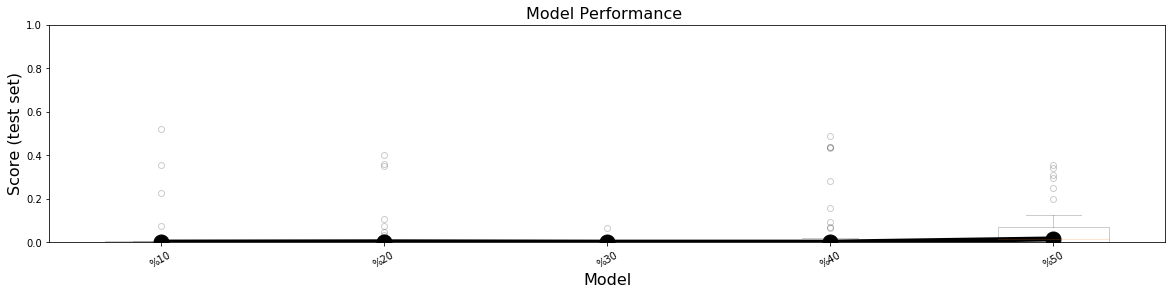

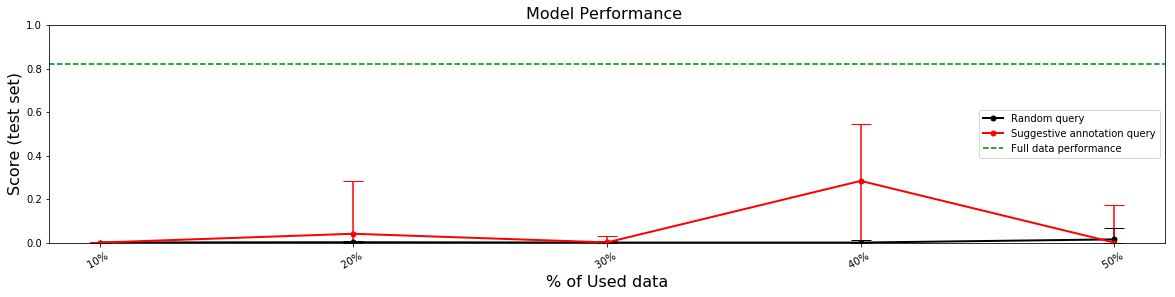

In [22]:
generate_plot(X_rand,X_sg,Ndata)